In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
import os
print(os.getcwd())

/home/srp/research/Fairness/fairness_AL/codes


In [3]:
!nvidia-smi

Fri Apr 15 00:18:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
|  0%   26C    P8     7W / 257W |   3631MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
|  0%   

In [4]:
device = torch.device('cuda:4')

In [5]:
from utils.test_utils import obtain_AL_ckpts, split_AL_loaders
from utils.test_utils import load_AL_config, load_AL_dataloader, load_test_model, test_group_perf

In [371]:
save_dir = "../results/simulation/220416_1456"
config_file, state_list, data_files, arg_file = obtain_AL_ckpts(save_dir)

In [372]:
print(state_list, data_files)

['binaryNN_0.pt', 'binaryNN_1.pt', 'binaryNN_10.pt', 'binaryNN_11.pt', 'binaryNN_12.pt', 'binaryNN_13.pt', 'binaryNN_14.pt', 'binaryNN_15.pt', 'binaryNN_16.pt', 'binaryNN_17.pt', 'binaryNN_18.pt', 'binaryNN_19.pt', 'binaryNN_2.pt', 'binaryNN_20.pt', 'binaryNN_21.pt', 'binaryNN_22.pt', 'binaryNN_23.pt', 'binaryNN_24.pt', 'binaryNN_25.pt', 'binaryNN_26.pt', 'binaryNN_27.pt', 'binaryNN_28.pt', 'binaryNN_29.pt', 'binaryNN_3.pt', 'binaryNN_30.pt', 'binaryNN_31.pt', 'binaryNN_32.pt', 'binaryNN_33.pt', 'binaryNN_34.pt', 'binaryNN_35.pt', 'binaryNN_36.pt', 'binaryNN_37.pt', 'binaryNN_38.pt', 'binaryNN_39.pt', 'binaryNN_4.pt', 'binaryNN_40.pt', 'binaryNN_41.pt', 'binaryNN_42.pt', 'binaryNN_43.pt', 'binaryNN_44.pt', 'binaryNN_45.pt', 'binaryNN_46.pt', 'binaryNN_47.pt', 'binaryNN_48.pt', 'binaryNN_49.pt', 'binaryNN_5.pt', 'binaryNN_50.pt', 'binaryNN_51.pt', 'binaryNN_52.pt', 'binaryNN_53.pt', 'binaryNN_54.pt', 'binaryNN_55.pt', 'binaryNN_56.pt', 'binaryNN_57.pt', 'binaryNN_58.pt', 'binaryNN_59.pt

### load models and train data loaders

In [373]:
args = load_AL_config(save_dir, config_file)
dl_loader = load_AL_dataloader(args.save_dir,'final_dataloader.pkl')
test_loader = load_AL_dataloader(args.save_dir,'test_loader.pkl')

In [374]:
dl_loaders,dl_cum_loaders = split_AL_loaders(dl_loader, args)

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)


In [375]:
import pickle, os
with open(os.path.join(args.save_dir, 'selected_group_results.pkl'),'rb') as f:
    gids = pickle.load(f)

In [376]:
from utils.test_utils import test_groupwise, test_model

In [377]:
from sklearn.linear_model import LogisticRegression as LogR

In [378]:
def dic2logdic(log_gs, log_g, tag = 'train'):
    if len(log_gs[tag].keys())==0:
        for zi in log_g.keys():
            log_gs[tag][zi] = []
            
    for zi in log_g.keys():
        
        log_gs[tag][zi].append(log_g[zi])
    return log_gs

In [379]:
loss_gs = {}
acc_gs = {}
loss_log = {}
acc_log = {}

loss_gs['train'] = {}
loss_gs['test'] = {}
acc_gs['train'] = {}
acc_gs['test'] = {}

loss_log['train'] = []
loss_log['test'] = []
acc_log['train'] = []
acc_log['test'] = []

loss_log['train_w'] = []
loss_log['test_w'] = []
acc_log['train_w'] = []
acc_log['test_w'] = []

for it in range(len(state_list)):
    st = args.problem_type+args.model_type +"_"+ str(it)+ ".pt"
    print("="*50)
    clf,clf_criterion = load_test_model(save_dir, st, args)
    loss, acc = test_model(clf, dl_cum_loaders[it],clf_criterion, device, args.problem_type)
    acc_log['train'].append(acc.item())
    loss_log['train'].append(loss.item())
    
    loss, acc2 = test_model(clf, test_loader,clf_criterion, device, args.problem_type)
    acc_log['test'].append(acc2.item())
    loss_log['test'].append(loss.item())
    
    lrclf = LogR().fit(dl_cum_loaders[it].dataset.tensors[0].numpy(),dl_cum_loaders[it].dataset.tensors[1].numpy())
    acc3 = lrclf.score(dl_cum_loaders[it].dataset.tensors[0].numpy(),dl_cum_loaders[it].dataset.tensors[1].numpy())
    acc4 = lrclf.score(test_loader.dataset.tensors[0].numpy(),test_loader.dataset.tensors[1].numpy())
    print("cumulated total training/test acc:", acc,"/",acc2,"/",acc3*100,"/",acc4*100)
    loss_g, acc_g,loss_w, acc_w = test_group_perf(clf, dl_cum_loaders[it],clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
    loss_gs = dic2logdic(loss_gs, loss_g, tag = 'train')
    acc_gs = dic2logdic(acc_gs, acc_g, tag = 'train')
    loss_log['train_w'].append(loss_w)
    acc_log['train_w'].append(acc_w)
    
    print("test set performance")
    loss_g, acc_g, loss_w, acc_w = test_group_perf(clf, test_loader,clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
    loss_gs = dic2logdic(loss_gs, loss_g, tag = 'test')
    acc_gs = dic2logdic(acc_gs, acc_g, tag = 'test')
    loss_log['test_w'].append(loss_w)
    acc_log['test_w'].append(acc_w)
    
    print("selected group is", gids[it])
    print('-'*50)
    for i in range(it+1):
        _, acc = test_model(clf, dl_loaders[i],clf_criterion, device, args.problem_type)
        print("data loader",i, "acc:",acc)
        test_groupwise(clf, dl_loaders[i],clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
        print("")

loaded model is binaryNN_0.pt
cumulated total training/test acc: tensor(84.) / tensor(63.4958) / 96.0 / 70.3923900118906
0.0 : loss 0.42151278257369995 / acc 82.85713958740234
1.0 : loss 0.31795811653137207 / acc 86.66666412353516
test set performance
0.0 : loss 0.7227758169174194 / acc 64.23841094970703
1.0 : loss 0.799018919467926 / acc 61.60337448120117
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(84.)
0.0 : loss 0.42151278257369995 / acc 82.85713958740234
1.0 : loss 0.31795811653137207 / acc 86.66666412353516

loaded model is binaryNN_1.pt
cumulated total training/test acc: tensor(88.6364) / tensor(64.8038) / 96.21212121212122 / 73.36504161712247
0.0 : loss 0.2881529629230499 / acc 92.13483428955078
1.0 : loss 0.4321426451206207 / acc 81.39534759521484
test set performance
0.0 : loss 0.77181476354599 / acc 65.06622314453125
1.0 : loss 0.8199641108512878 / acc 64.13501739501953
selected group is 1.0
------------------------------

/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/ut

tensor(89.0244) / tensor(63.7337) / 94.51219512195121 / 73.24613555291319
0.0 : loss 0.3552723526954651 / acc 87.71929931640625
1.0 : loss 0.32030826807022095 / acc 92.0
test set performance
0.0 : loss 0.6759873628616333 / acc 64.07284545898438
1.0 : loss 0.7232538461685181 / acc 62.869197845458984
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(86.)
0.0 : loss 0.3755582273006439 / acc 85.71428680419922
1.0 : loss 0.36024489998817444 / acc 86.66666412353516

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.41147780418395996 / acc 84.21052551269531
1.0 : loss 0.24287149310112 / acc 100.0

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.2557559013366699 / acc 96.0
1.0 : loss 0.29296252131462097 / acc 100.0

loaded model is binaryNN_3.pt
cumulated total training/test acc: tensor(84.6939) / tensor(63.4958) / 92.85714285714286 / 75.26753864447086
0.0 : loss 0.34097832441329956 / acc 85.10638427734375
1.0 : loss 0.3365161418914795 / acc 83.63

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.

2 acc: tensor(87.5000)
0.0 : loss 0.28854677081108093 / acc 88.0
1.0 : loss 0.31887784600257874 / acc 85.71428680419922

data loader 3 acc: tensor(56.2500)
0.0 : loss 0.5975138545036316 / acc 55.55555725097656
1.0 : loss 0.6010209918022156 / acc 60.0

data loader 4 acc: tensor(96.8750)
0.0 : loss 0.24379098415374756 / acc 96.15384674072266
1.0 : loss 0.3599938750267029 / acc 100.0

loaded model is binaryNN_5.pt
cumulated total training/test acc: tensor(81.9231) / tensor(65.8740) / 93.07692307692308 / 76.09988109393579
0.0 : loss 0.37150222063064575 / acc 82.1989517211914
1.0 : loss 0.4503859877586365 / acc 81.159423828125
test set performance
0.0 : loss 0.6938672065734863 / acc 66.22516632080078
1.0 : loss 0.7419497966766357 / acc 64.9789047241211
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(80.)
0.0 : loss 0.3653971552848816 / acc 82.85713958740234
1.0 : loss 0.49545636773109436 / acc 73.33332824707031

data loader 1 acc: tensor(81

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.


data loader 4 acc: tensor(96.8750)
0.0 : loss 0.15034499764442444 / acc 96.15384674072266
1.0 : loss 0.2530295252799988 / acc 100.0

data loader 5 acc: tensor(75.)
0.0 : loss 0.40940651297569275 / acc 79.16666412353516
1.0 : loss 0.9197257161140442 / acc 62.5

data loader 6 acc: tensor(93.7500)
0.0 : loss 0.17715270817279816 / acc 92.85713958740234
1.0 : loss 0.032067734748125076 / acc 100.0

loaded model is binaryNN_7.pt
cumulated total training/test acc: tensor(87.0370) / tensor(68.7277) / 93.20987654320987 / 76.45659928656362
0.0 : loss 0.29657119512557983 / acc 87.55186462402344
1.0 : loss 0.39493200182914734 / acc 85.54216766357422
test set performance
0.0 : loss 0.7913902401924133 / acc 68.21192169189453
1.0 : loss 0.7762795686721802 / acc 70.04219055175781
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(84.)
0.0 : loss 0.3700089454650879 / acc 82.85713958740234
1.0 : loss 0.4810195565223694 / acc 86.66666412353516

data loader 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.

1.0 : loss 0.4817841053009033 / acc 73.33332824707031

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.40532609820365906 / acc 89.47368621826172
1.0 : loss 0.33447274565696716 / acc 84.61537170410156

data loader 2 acc: tensor(81.2500)
0.0 : loss 0.30508890748023987 / acc 80.0
1.0 : loss 0.2446693629026413 / acc 85.71428680419922

data loader 3 acc: tensor(87.5000)
0.0 : loss 0.3955085873603821 / acc 88.88888549804688
1.0 : loss 0.5043869614601135 / acc 80.0

data loader 4 acc: tensor(93.7500)
0.0 : loss 0.19397065043449402 / acc 96.15384674072266
1.0 : loss 0.3508952558040619 / acc 83.33332824707031

data loader 5 acc: tensor(68.7500)
0.0 : loss 0.5837987661361694 / acc 66.66666412353516
1.0 : loss 0.7514874339103699 / acc 75.0

data loader 6 acc: tensor(93.7500)
0.0 : loss 0.27401989698410034 / acc 92.85713958740234
1.0 : loss 0.08486050367355347 / acc 100.0

data loader 7 acc: tensor(84.3750)
0.0 : loss 0.33035901188850403 / acc 90.90908813476562
1.0 : loss 0.37286052107810974 / acc

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.

0.0 : loss 0.423972487449646 / acc 81.5873031616211
1.0 : loss 0.47268784046173096 / acc 79.04762268066406
test set performance
0.0 : loss 0.5806245803833008 / acc 71.85430145263672
1.0 : loss 0.6668676733970642 / acc 67.51055145263672
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.4433247745037079 / acc 78.57142639160156
1.0 : loss 0.5452696084976196 / acc 66.66666412353516

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.4694453179836273 / acc 78.9473648071289
1.0 : loss 0.41061776876449585 / acc 84.61537170410156

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.3209816813468933 / acc 88.0
1.0 : loss 0.2551151514053345 / acc 100.0

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.533283531665802 / acc 77.77777862548828
1.0 : loss 0.4084087312221527 / acc 80.0

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.33390626311302185 / acc 84.61537170410156
1.0 : loss 0.2672434449195862 / acc 100.0

data loader 5 acc: tensor

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.

0.0 : loss 0.5419083833694458 / acc 72.35099029541016
1.0 : loss 0.6699014902114868 / acc 67.08860778808594
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.5073463916778564 / acc 74.28571319580078
1.0 : loss 0.39168986678123474 / acc 76.66666412353516

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.5699129700660706 / acc 84.21052551269531
1.0 : loss 0.4159433841705322 / acc 76.9230728149414

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.27914631366729736 / acc 88.0
1.0 : loss 0.34416791796684265 / acc 71.42857360839844

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.5151870250701904 / acc 70.37036895751953
1.0 : loss 0.48639750480651855 / acc 80.0

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.3470081686973572 / acc 84.61537170410156
1.0 : loss 0.4011933207511902 / acc 100.0

data loader 5 acc: tensor(53.1250)
0.0 : loss 0.6637563109397888 / acc 50.0
1.0 : loss 0.9735168814659119 / acc 62.5

data loader 6 acc: t

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.

10 acc: tensor(75.)
0.0 : loss 0.5767803192138672 / acc 74.0740737915039
1.0 : loss 0.35955846309661865 / acc 80.0

data loader 11 acc: tensor(71.8750)
0.0 : loss 0.5449540019035339 / acc 75.0
1.0 : loss 0.9196171164512634 / acc 62.5

data loader 12 acc: tensor(71.8750)
0.0 : loss 0.5075607299804688 / acc 69.56521606445312
1.0 : loss 0.5228853225708008 / acc 77.77777099609375

data loader 13 acc: tensor(93.7500)
0.0 : loss 0.2327752560377121 / acc 89.47368621826172
1.0 : loss 0.18984973430633545 / acc 100.0

data loader 14 acc: tensor(71.8750)
0.0 : loss 0.48068925738334656 / acc 70.0
1.0 : loss 0.4820140600204468 / acc 75.0

loaded model is binaryNN_15.pt
cumulated total training/test acc: tensor(80.1724) / tensor(72.5327) / 92.58620689655173 / 84.18549346016647
0.0 : loss 0.4177578091621399 / acc 80.09478759765625
1.0 : loss 0.4485478699207306 / acc 80.37974548339844
test set performance
0.0 : loss 0.5624520182609558 / acc 72.8476791381836
1.0 : loss 0.6795097589492798 / acc 71.72995

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.

cumulated total training/test acc: tensor(81.5359) / tensor(72.1760) / 92.64705882352942 / 83.82877526753865
0.0 : loss 0.3822762370109558 / acc 82.47190856933594
1.0 : loss 0.42613646388053894 / acc 79.04191589355469
test set performance
0.0 : loss 0.5889726281166077 / acc 72.68212127685547
1.0 : loss 0.7018678188323975 / acc 70.88607788085938
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(79.)
0.0 : loss 0.45816725492477417 / acc 80.0
1.0 : loss 0.49099546670913696 / acc 76.66666412353516

data loader 1 acc: tensor(84.3750)
0.0 : loss 0.36152884364128113 / acc 84.21052551269531
1.0 : loss 0.25019726157188416 / acc 84.61537170410156

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.18680956959724426 / acc 96.0
1.0 : loss 0.17895786464214325 / acc 100.0

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.5723758935928345 / acc 66.66666412353516
1.0 : loss 0.27119430899620056 / acc 100.0

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.262

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.


data loader 8 acc: tensor(81.2500)
0.0 : loss 0.4849909245967865 / acc 73.91304016113281
1.0 : loss 0.26866069436073303 / acc 100.0

data loader 9 acc: tensor(81.2500)
0.0 : loss 0.3540721833705902 / acc 83.33332824707031
1.0 : loss 0.4598456621170044 / acc 75.0

data loader 10 acc: tensor(75.)
0.0 : loss 0.5835781693458557 / acc 70.37036895751953
1.0 : loss 0.39989861845970154 / acc 100.0

data loader 11 acc: tensor(68.7500)
0.0 : loss 0.5557838678359985 / acc 70.83332824707031
1.0 : loss 0.9939295649528503 / acc 62.5

data loader 12 acc: tensor(62.5000)
0.0 : loss 0.7707652449607849 / acc 60.869564056396484
1.0 : loss 0.8209648728370667 / acc 66.66666412353516

data loader 13 acc: tensor(90.6250)
0.0 : loss 0.2759381830692291 / acc 89.47368621826172
1.0 : loss 0.2358126938343048 / acc 92.30769348144531

data loader 14 acc: tensor(56.2500)
0.0 : loss 0.6818084120750427 / acc 55.0
1.0 : loss 0.7395018935203552 / acc 58.33333206176758

data loader 15 acc: tensor(81.2500)
0.0 : loss 0.3

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.

1.0 : loss 0.48229074478149414 / acc 80.0

data loader 11 acc: tensor(78.1250)
0.0 : loss 0.3939351439476013 / acc 83.33332824707031
1.0 : loss 1.1953436136245728 / acc 62.5

data loader 12 acc: tensor(62.5000)
0.0 : loss 0.5907029509544373 / acc 65.21739196777344
1.0 : loss 0.7992432713508606 / acc 55.5555534362793

data loader 13 acc: tensor(93.7500)
0.0 : loss 0.24482601881027222 / acc 94.7368392944336
1.0 : loss 0.21203187108039856 / acc 92.30769348144531

data loader 14 acc: tensor(62.5000)
0.0 : loss 0.5423430800437927 / acc 65.0
1.0 : loss 0.6868400573730469 / acc 58.33333206176758

data loader 15 acc: tensor(81.2500)
0.0 : loss 0.3246471881866455 / acc 80.95237731933594
1.0 : loss 0.3041442930698395 / acc 81.81818389892578

data loader 16 acc: tensor(100.)
0.0 : loss 0.20040516555309296 / acc 100.0
1.0 : loss 0.2910171151161194 / acc 100.0

data loader 17 acc: tensor(65.6250)
0.0 : loss 0.5723244547843933 / acc 60.0
1.0 : loss 0.3417857885360718 / acc 85.71428680419922

data lo

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0 : loss 0.6980066895484924 / acc 65.21739196777344
1.0 : loss 0.8792344331741333 / acc 44.44444274902344

data loader 13 acc: tensor(90.6250)
0.0 : loss 0.29936107993125916 / acc 89.47368621826172
1.0 : loss 0.2614932954311371 / acc 92.30769348144531

data loader 14 acc: tensor(56.2500)
0.0 : loss 0.6213982701301575 / acc 55.0
1.0 : loss 0.7773281931877136 / acc 58.33333206176758

data loader 15 acc: tensor(81.2500)
0.0 : loss 0.42077502608299255 / acc 80.95237731933594
1.0 : loss 0.36472755670547485 / acc 81.81818389892578

data loader 16 acc: tensor(96.8750)
0.0 : loss 0.23483912646770477 / acc 95.65217590332031
1.0 : loss 0.3049657344818115 / acc 100.0

data loader 17 acc: tensor(65.6250)
0.0 : loss 0.7091012597084045 / acc 60.0
1.0 : loss 0.39968496561050415 / acc 85.71428680419922

data loader 18 acc: tensor(93.7500)
0.0 : loss 0.1690140813589096 / acc 100.0
1.0 : loss 0.3764920234680176 / acc 77.77777099609375

data loader 19 acc: tensor(56.2500)
0.0 : loss 0.6644417643547058 

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0 : loss 0.5293058156967163 / acc 75.0
1.0 : loss 1.2082295417785645 / acc 62.5

data loader 12 acc: tensor(65.6250)
0.0 : loss 0.6750479936599731 / acc 69.56521606445312
1.0 : loss 0.800537109375 / acc 55.5555534362793

data loader 13 acc: tensor(87.5000)
0.0 : loss 0.2961885333061218 / acc 84.21052551269531
1.0 : loss 0.3367421627044678 / acc 92.30769348144531

data loader 14 acc: tensor(59.3750)
0.0 : loss 0.5838465094566345 / acc 60.0
1.0 : loss 0.7580558657646179 / acc 58.33333206176758

data loader 15 acc: tensor(81.2500)
0.0 : loss 0.4356856644153595 / acc 80.95237731933594
1.0 : loss 0.4217568039894104 / acc 81.81818389892578

data loader 16 acc: tensor(93.7500)
0.0 : loss 0.25920572876930237 / acc 100.0
1.0 : loss 0.3774016201496124 / acc 77.77777099609375

data loader 17 acc: tensor(65.6250)
0.0 : loss 0.6143921613693237 / acc 64.0
1.0 : loss 0.49279987812042236 / acc 71.42857360839844

data loader 18 acc: tensor(96.8750)
0.0 : loss 0.1385497897863388 / acc 100.0
1.0 : loss

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



data loader 8 acc: tensor(75.)
0.0 : loss 0.5125975012779236 / acc 73.91304016113281
1.0 : loss 0.41964951157569885 / acc 77.77777099609375

data loader 9 acc: tensor(87.5000)
0.0 : loss 0.28368696570396423 / acc 91.66666412353516
1.0 : loss 0.5176002979278564 / acc 75.0

data loader 10 acc: tensor(68.7500)
0.0 : loss 0.5098968744277954 / acc 70.37036895751953
1.0 : loss 0.5675598978996277 / acc 60.0

data loader 11 acc: tensor(71.8750)
0.0 : loss 0.5263786315917969 / acc 75.0
1.0 : loss 1.348218560218811 / acc 62.5

data loader 12 acc: tensor(62.5000)
0.0 : loss 0.668296217918396 / acc 65.21739196777344
1.0 : loss 0.8508629202842712 / acc 55.5555534362793

data loader 13 acc: tensor(90.6250)
0.0 : loss 0.2793222963809967 / acc 89.47368621826172
1.0 : loss 0.32967814803123474 / acc 92.30769348144531

data loader 14 acc: tensor(59.3750)
0.0 : loss 0.6432934999465942 / acc 60.0
1.0 : loss 0.721259593963623 / acc 58.33333206176758

data loader 15 acc: tensor(81.2500)
0.0 : loss 0.3930438

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4 acc: tensor(84.3750)
0.0 : loss 0.4395999014377594 / acc 84.61537170410156
1.0 : loss 0.416631817817688 / acc 83.33332824707031

data loader 5 acc: tensor(65.6250)
0.0 : loss 0.546413779258728 / acc 66.66666412353516
1.0 : loss 0.8691087365150452 / acc 62.5

data loader 6 acc: tensor(68.7500)
0.0 : loss 0.47960537672042847 / acc 71.42857360839844
1.0 : loss 0.7976440787315369 / acc 50.0

data loader 7 acc: tensor(84.3750)
0.0 : loss 0.3025529682636261 / acc 90.90908813476562
1.0 : loss 0.8093616366386414 / acc 70.0

data loader 8 acc: tensor(71.8750)
0.0 : loss 0.5024091601371765 / acc 65.21739196777344
1.0 : loss 0.35629522800445557 / acc 88.88888549804688

data loader 9 acc: tensor(78.1250)
0.0 : loss 0.2947227954864502 / acc 87.5
1.0 : loss 0.6094750165939331 / acc 50.0

data loader 10 acc: tensor(71.8750)
0.0 : loss 0.46755892038345337 / acc 74.0740737915039
1.0 : loss 0.501526951789856 / acc 60.0

data loader 11 acc: tensor(71.8750)
0.0 : loss 0.562744140625 / acc 75.0
1.0 : los

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tensor(81.2500)
0.0 : loss 0.38969841599464417 / acc 84.21052551269531
1.0 : loss 0.4235214591026306 / acc 76.9230728149414

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.3190581202507019 / acc 88.0
1.0 : loss 0.3449043035507202 / acc 85.71428680419922

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.5044369101524353 / acc 66.66666412353516
1.0 : loss 0.21456384658813477 / acc 100.0

data loader 4 acc: tensor(78.1250)
0.0 : loss 0.45826399326324463 / acc 76.9230728149414
1.0 : loss 0.46150916814804077 / acc 83.33332824707031

data loader 5 acc: tensor(68.7500)
0.0 : loss 0.5646514296531677 / acc 70.83332824707031
1.0 : loss 0.737930953502655 / acc 62.5

data loader 6 acc: tensor(75.)
0.0 : loss 0.4013153910636902 / acc 78.57142639160156
1.0 : loss 0.679667055606842 / acc 50.0

data loader 7 acc: tensor(78.1250)
0.0 : loss 0.35236966609954834 / acc 81.81818389892578
1.0 : loss 0.6609444618225098 / acc 70.0

data loader 8 acc: tensor(78.1250)
0.0 : loss 0.4855891466140747 / acc 73.9130

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0 : loss 0.4765975773334503 / acc 77.48344421386719
1.0 : loss 0.6340868473052979 / acc 73.417724609375
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(74.)
0.0 : loss 0.5108372569084167 / acc 77.14286041259766
1.0 : loss 0.512572169303894 / acc 66.66666412353516

data loader 1 acc: tensor(78.1250)
0.0 : loss 0.37814950942993164 / acc 78.9473648071289
1.0 : loss 0.4157642424106598 / acc 76.9230728149414

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.28843772411346436 / acc 88.0
1.0 : loss 0.2942318320274353 / acc 100.0

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.514072835445404 / acc 66.66666412353516
1.0 : loss 0.15595953166484833 / acc 100.0

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.4437086582183838 / acc 80.76923370361328
1.0 : loss 0.2950606048107147 / acc 100.0

data loader 5 acc: tensor(71.8750)
0.0 : loss 0.5092880725860596 / acc 75.0
1.0 : loss 0.8031672835350037 / acc 62.5

data loader 6 acc: tensor(71.8750)
0.

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


1.0 : loss 0.4961622655391693 / acc 76.98113250732422
test set performance
0.0 : loss 0.4760906994342804 / acc 78.80794525146484
1.0 : loss 0.6622558236122131 / acc 70.88607788085938
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(76.)
0.0 : loss 0.48217496275901794 / acc 77.14286041259766
1.0 : loss 0.4625862240791321 / acc 73.33332824707031

data loader 1 acc: tensor(78.1250)
0.0 : loss 0.37450772523880005 / acc 78.9473648071289
1.0 : loss 0.37120240926742554 / acc 76.9230728149414

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.26568087935447693 / acc 92.0
1.0 : loss 0.2990059554576874 / acc 100.0

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.4943702220916748 / acc 66.66666412353516
1.0 : loss 0.17144618928432465 / acc 100.0

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.4377523362636566 / acc 80.76923370361328
1.0 : loss 0.26370155811309814 / acc 100.0

data loader 5 acc: tensor(68.7500)
0.0 : loss 0.5181212425231934 / acc 70

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(80.6225) / tensor(75.9810) / 90.96385542168674 / 87.99048751486326
0.0 : loss 0.3786565363407135 / acc 81.58995819091797
1.0 : loss 0.48319733142852783 / acc 78.13619995117188
test set performance
0.0 : loss 0.5083916783332825 / acc 77.64900970458984
1.0 : loss 0.673014223575592 / acc 71.7299575805664
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(72.)
0.0 : loss 0.5722036957740784 / acc 72.85713958740234
1.0 : loss 0.48840612173080444 / acc 70.0

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.3666985332965851 / acc 84.21052551269531
1.0 : loss 0.38466453552246094 / acc 76.9230728149414

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.28941547870635986 / acc 88.0
1.0 : loss 0.2318301796913147 / acc 100.0

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.4771305322647095 / acc 74.0740737915039
1.0 : loss 0.1293138712644577 / acc 100.0

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.41766196489

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(82.4903) / tensor(76.9322) / 90.75875486381322 / 88.58501783590962
0.0 : loss 0.35632598400115967 / acc 83.8274917602539
1.0 : loss 0.480632483959198 / acc 79.02098083496094
test set performance
0.0 : loss 0.47734084725379944 / acc 78.80794525146484
1.0 : loss 0.6555173993110657 / acc 72.15190124511719
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(76.)
0.0 : loss 0.5015459060668945 / acc 78.57142639160156
1.0 : loss 0.5809246301651001 / acc 70.0

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.2887960970401764 / acc 84.21052551269531
1.0 : loss 0.3193597197532654 / acc 76.9230728149414

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.2196028083562851 / acc 92.0
1.0 : loss 0.19118407368659973 / acc 100.0

data loader 3 acc: tensor(75.)
0.0 : loss 0.4329335391521454 / acc 70.37036895751953
1.0 : loss 0.13819687068462372 / acc 100.0

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.40725862979888

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(77.7358) / tensor(77.6457) / 91.13207547169812 / 88.58501783590962
0.0 : loss 0.4282973110675812 / acc 78.89908599853516
1.0 : loss 0.5311830043792725 / acc 74.74747467041016
test set performance
0.0 : loss 0.45914459228515625 / acc 79.13907623291016
1.0 : loss 0.6218067407608032 / acc 73.83966064453125
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.5597240924835205 / acc 72.85713958740234
1.0 : loss 0.47601616382598877 / acc 80.0

data loader 1 acc: tensor(78.1250)
0.0 : loss 0.4351000487804413 / acc 78.9473648071289
1.0 : loss 0.39426812529563904 / acc 76.9230728149414

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.3523210883140564 / acc 88.0
1.0 : loss 0.3059825003147125 / acc 85.71428680419922

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.5950283408164978 / acc 66.66666412353516
1.0 : loss 0.15271399915218353 / acc 100.0

data loader 4 acc: tensor(78.1250)
0.0 : loss

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(84.7985) / tensor(76.8133) / 90.56776556776556 / 88.58501783590962
0.0 : loss 0.31693410873413086 / acc 85.3875503540039
1.0 : loss 0.41931360960006714 / acc 83.2786865234375
test set performance
0.0 : loss 0.49870309233665466 / acc 79.47019958496094
1.0 : loss 0.7289209365844727 / acc 70.04219055175781
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(76.)
0.0 : loss 0.5195212960243225 / acc 75.71428680419922
1.0 : loss 0.46352145075798035 / acc 76.66666412353516

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.31296685338020325 / acc 78.9473648071289
1.0 : loss 0.2810598611831665 / acc 84.61537170410156

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.23320847749710083 / acc 92.0
1.0 : loss 0.14281456172466278 / acc 100.0

data loader 3 acc: tensor(87.5000)
0.0 : loss 0.37106266617774963 / acc 85.18518829345703
1.0 : loss 0.12214536964893341 / acc 100.0

data loader 4 acc: tensor(84.3750)
0.0 :

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(83.9858) / tensor(76.6944) / 90.48042704626334 / 88.46611177170035
0.0 : loss 0.352931946516037 / acc 84.51053619384766
1.0 : loss 0.4491104185581207 / acc 82.64984130859375
test set performance
0.0 : loss 0.48602455854415894 / acc 77.81456756591797
1.0 : loss 0.6244287490844727 / acc 73.83966064453125
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(72.)
0.0 : loss 0.5305705070495605 / acc 72.85713958740234
1.0 : loss 0.5732775926589966 / acc 70.0

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.2719072699546814 / acc 94.7368392944336
1.0 : loss 0.3021945059299469 / acc 76.9230728149414

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.2101687639951706 / acc 92.0
1.0 : loss 0.14238660037517548 / acc 100.0

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.41898536682128906 / acc 81.48148345947266
1.0 : loss 0.18203294277191162 / acc 100.0

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.3150736391

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))



data loader 18 acc: tensor(96.8750)
0.0 : loss 0.13975995779037476 / acc 100.0
1.0 : loss 0.37545377016067505 / acc 88.88888549804688

data loader 19 acc: tensor(75.)
0.0 : loss 0.5352097749710083 / acc 75.0
1.0 : loss 0.5800595879554749 / acc 75.0

data loader 20 acc: tensor(71.8750)
0.0 : loss 0.3322001099586487 / acc 85.71428680419922
1.0 : loss 0.7281491756439209 / acc 45.45454406738281

data loader 21 acc: tensor(71.8750)
0.0 : loss 0.610745906829834 / acc 70.0
1.0 : loss 0.43067941069602966 / acc 75.0

data loader 22 acc: tensor(75.)
0.0 : loss 0.4237193763256073 / acc 77.2727279663086
1.0 : loss 0.562243640422821 / acc 70.0

data loader 23 acc: tensor(84.3750)
0.0 : loss 0.24963265657424927 / acc 92.0
1.0 : loss 0.7441336512565613 / acc 57.14285659790039

data loader 24 acc: tensor(87.5000)
0.0 : loss 0.3951268196105957 / acc 84.61537170410156
1.0 : loss 0.28887030482292175 / acc 100.0

data loader 25 acc: tensor(75.)
0.0 : loss 0.3957182466983795 / acc 77.2727279663086
1.0 : l

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.17782220244407654 / acc 96.0
1.0 : loss 0.12728290259838104 / acc 100.0

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.40868905186653137 / acc 77.77777862548828
1.0 : loss 0.17126403748989105 / acc 100.0

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.3087538182735443 / acc 84.61537170410156
1.0 : loss 0.16856834292411804 / acc 100.0

data loader 5 acc: tensor(75.)
0.0 : loss 0.4075513780117035 / acc 75.0
1.0 : loss 0.9050114750862122 / acc 75.0

data loader 6 acc: tensor(90.6250)
0.0 : loss 0.22212594747543335 / acc 96.42857360839844
1.0 : loss 0.634918212890625 / acc 50.0

data loader 7 acc: tensor(84.3750)
0.0 : loss 0.18633636832237244 / acc 90.90908813476562
1.0 : loss 0.6635177731513977 / acc 70.0

data loader 8 acc: tensor(90.6250)
0.0 : loss 0.23511841893196106 / acc 91.3043441772461
1.0 : loss 0.29011502861976624 / acc 88.88888549804688

data loader 9 acc: tensor(87.5000)
0.0 : loss 0.21707050502300262 / acc 95.83333587646484
1.0 : loss 0.5183086395263672 / acc

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(79.8361) / tensor(76.3377) / 90.1639344262295 / 88.46611177170035
0.0 : loss 0.4162122309207916 / acc 81.30734252929688
1.0 : loss 0.5152052044868469 / acc 76.14942169189453
test set performance
0.0 : loss 0.480024129152298 / acc 78.3112564086914
1.0 : loss 0.6115708351135254 / acc 71.30801391601562
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(73.)
0.0 : loss 0.5535078644752502 / acc 75.71428680419922
1.0 : loss 0.5831745862960815 / acc 66.66666412353516

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.34935563802719116 / acc 84.21052551269531
1.0 : loss 0.3946087956428528 / acc 76.9230728149414

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.28400325775146484 / acc 88.0
1.0 : loss 0.3138653635978699 / acc 85.71428680419922

data loader 3 acc: tensor(75.)
0.0 : loss 0.4801822602748871 / acc 70.37036895751953
1.0 : loss 0.16002438962459564 / acc 100.0

data loader 4 acc: tensor(81.2500)
0.0 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


acc: tensor(75.)
0.0 : loss 0.347141295671463 / acc 75.0
1.0 : loss 0.6863837242126465 / acc 75.0

data loader 15 acc: tensor(84.3750)
0.0 : loss 0.37400588393211365 / acc 80.95237731933594
1.0 : loss 0.2993365228176117 / acc 90.90908813476562

data loader 16 acc: tensor(96.8750)
0.0 : loss 0.14373533427715302 / acc 100.0
1.0 : loss 0.20532284677028656 / acc 88.88888549804688

data loader 17 acc: tensor(78.1250)
0.0 : loss 0.37175074219703674 / acc 76.0
1.0 : loss 0.3311844766139984 / acc 85.71428680419922

data loader 18 acc: tensor(96.8750)
0.0 : loss 0.0703180581331253 / acc 100.0
1.0 : loss 0.3007144033908844 / acc 88.88888549804688

data loader 19 acc: tensor(78.1250)
0.0 : loss 0.43870434165000916 / acc 79.16666412353516
1.0 : loss 0.535402774810791 / acc 75.0

data loader 20 acc: tensor(75.)
0.0 : loss 0.23847614228725433 / acc 90.47618865966797
1.0 : loss 0.6241496801376343 / acc 45.45454406738281

data loader 21 acc: tensor(81.2500)
0.0 : loss 0.42314884066581726 / acc 75.0
1.

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.34336966276168823 / acc 84.73282623291016
1.0 : loss 0.4774697422981262 / acc 76.56675720214844
test set performance
0.0 : loss 0.41849035024642944 / acc 80.96026611328125
1.0 : loss 0.5726452469825745 / acc 74.26160430908203
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.4385780692100525 / acc 80.0
1.0 : loss 0.5364719033241272 / acc 70.0

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.3095608353614807 / acc 84.21052551269531
1.0 : loss 0.3581697940826416 / acc 76.9230728149414

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.2365221381187439 / acc 92.0
1.0 : loss 0.22921541333198547 / acc 100.0

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.44445690512657166 / acc 74.0740737915039
1.0 : loss 0.16392962634563446 / acc 100.0

data loader 4 acc: tensor(81.2500)
0.0 : loss 0.3839762210845947 / acc 76.9230728149414
1.0 : loss 0.2547489106655121 / acc 100.0

data loader 5 acc: tensor(71.8750)
0.0 : loss 0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(80.0912) / tensor(78.3591) / 89.36170212765957 / 88.82282996432818
0.0 : loss 0.3722873628139496 / acc 82.21512603759766
1.0 : loss 0.5178544521331787 / acc 74.80106353759766
test set performance
0.0 : loss 0.42474955320358276 / acc 79.6357650756836
1.0 : loss 0.5881960391998291 / acc 75.10548400878906
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.47869446873664856 / acc 77.14286041259766
1.0 : loss 0.5759989023208618 / acc 70.0

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.36307114362716675 / acc 84.21052551269531
1.0 : loss 0.42020222544670105 / acc 76.9230728149414

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.26051950454711914 / acc 92.0
1.0 : loss 0.2464992105960846 / acc 100.0

data loader 3 acc: tensor(75.)
0.0 : loss 0.4840480089187622 / acc 70.37036895751953
1.0 : loss 0.13276076316833496 / acc 100.0

data loader 4 acc: tensor(81.2500)
0.0 : loss 0.41231241822

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


data loader 9 acc: tensor(87.5000)
0.0 : loss 0.24503681063652039 / acc 91.66666412353516
1.0 : loss 0.4837234914302826 / acc 75.0

data loader 10 acc: tensor(75.)
0.0 : loss 0.4431706964969635 / acc 77.77777862548828
1.0 : loss 0.4315199851989746 / acc 60.0

data loader 11 acc: tensor(78.1250)
0.0 : loss 0.40296563506126404 / acc 83.33332824707031
1.0 : loss 1.2379236221313477 / acc 62.5

data loader 12 acc: tensor(68.7500)
0.0 : loss 0.43816640973091125 / acc 69.56521606445312
1.0 : loss 0.7465786337852478 / acc 66.66666412353516

data loader 13 acc: tensor(87.5000)
0.0 : loss 0.23467914760112762 / acc 89.47368621826172
1.0 : loss 0.4257354140281677 / acc 84.61537170410156

data loader 14 acc: tensor(78.1250)
0.0 : loss 0.39847955107688904 / acc 80.0
1.0 : loss 0.6353839635848999 / acc 75.0

data loader 15 acc: tensor(84.3750)
0.0 : loss 0.28749167919158936 / acc 85.71428680419922
1.0 : loss 0.3338620662689209 / acc 81.81818389892578

data loader 16 acc: tensor(100.)
0.0 : loss 0.158

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(81.5942) / tensor(79.9049) / 89.27536231884058 / 88.34720570749109
0.0 : loss 0.36544808745384216 / acc 83.19755554199219
1.0 : loss 0.48845794796943665 / acc 77.63819122314453
test set performance
0.0 : loss 0.39942413568496704 / acc 81.62251281738281
1.0 : loss 0.5609996318817139 / acc 75.52742767333984
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(74.)
0.0 : loss 0.49796125292778015 / acc 72.85713958740234
1.0 : loss 0.4941631257534027 / acc 76.66666412353516

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.3422190546989441 / acc 84.21052551269531
1.0 : loss 0.45809152722358704 / acc 76.9230728149414

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.25676536560058594 / acc 92.0
1.0 : loss 0.21569861471652985 / acc 100.0

data loader 3 acc: tensor(75.)
0.0 : loss 0.5426140427589417 / acc 70.37036895751953
1.0 : loss 0.14559048414230347 / acc 100.0

data loader 4 acc: tensor(81.2500)
0.0 : lo

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


7 acc: tensor(87.5000)
0.0 : loss 0.2043921947479248 / acc 90.90908813476562
1.0 : loss 0.4876720607280731 / acc 80.0

data loader 8 acc: tensor(90.6250)
0.0 : loss 0.19376207888126373 / acc 91.3043441772461
1.0 : loss 0.20565812289714813 / acc 88.88888549804688

data loader 9 acc: tensor(96.8750)
0.0 : loss 0.17140905559062958 / acc 100.0
1.0 : loss 0.3271133303642273 / acc 87.5

data loader 10 acc: tensor(75.)
0.0 : loss 0.40486422181129456 / acc 77.77777862548828
1.0 : loss 0.46464863419532776 / acc 60.0

data loader 11 acc: tensor(84.3750)
0.0 : loss 0.22413812577724457 / acc 91.66666412353516
1.0 : loss 0.8316969871520996 / acc 62.5

data loader 12 acc: tensor(84.3750)
0.0 : loss 0.3503980338573456 / acc 86.9565200805664
1.0 : loss 0.5818745493888855 / acc 77.77777099609375

data loader 13 acc: tensor(84.3750)
0.0 : loss 0.2390570342540741 / acc 84.21052551269531
1.0 : loss 0.22104212641716003 / acc 84.61537170410156

data loader 14 acc: tensor(81.2500)
0.0 : loss 0.27805396914482

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(82.0637) / tensor(79.4293) / 89.54293628808865 / 88.34720570749109
0.0 : loss 0.35019224882125854 / acc 84.4143295288086
1.0 : loss 0.5083622336387634 / acc 76.15571594238281
test set performance
0.0 : loss 0.42876940965652466 / acc 81.95364379882812
1.0 : loss 0.604060709476471 / acc 72.99578094482422
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.4477604031562805 / acc 77.14286041259766
1.0 : loss 0.5185830593109131 / acc 76.66666412353516

data loader 1 acc: tensor(78.1250)
0.0 : loss 0.3446301221847534 / acc 89.47368621826172
1.0 : loss 0.45627331733703613 / acc 61.53845977783203

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.2783312499523163 / acc 96.0
1.0 : loss 0.18070819973945618 / acc 100.0

data loader 3 acc: tensor(75.)
0.0 : loss 0.4636955261230469 / acc 70.37036895751953
1.0 : loss 0.17861981689929962 / acc 100.0

data loader 4 acc: tensor(81.2500)
0.0 : loss 0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


tensor(93.7500)
0.0 : loss 0.2261172980070114 / acc 92.0
1.0 : loss 0.16973212361335754 / acc 100.0

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.4781705439090729 / acc 77.77777862548828
1.0 : loss 0.18092159926891327 / acc 100.0

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.34236153960227966 / acc 92.30769348144531
1.0 : loss 0.3390530049800873 / acc 83.33332824707031

data loader 5 acc: tensor(78.1250)
0.0 : loss 0.3969748020172119 / acc 79.16666412353516
1.0 : loss 0.763106107711792 / acc 75.0

data loader 6 acc: tensor(90.6250)
0.0 : loss 0.2481144815683365 / acc 96.42857360839844
1.0 : loss 0.6948621273040771 / acc 50.0

data loader 7 acc: tensor(84.3750)
0.0 : loss 0.25364676117897034 / acc 90.90908813476562
1.0 : loss 0.6933935284614563 / acc 70.0

data loader 8 acc: tensor(90.6250)
0.0 : loss 0.2880789339542389 / acc 91.3043441772461
1.0 : loss 0.2235611081123352 / acc 88.88888549804688

data loader 9 acc: tensor(84.3750)
0.0 : loss 0.24376744031906128 / acc 91.6666641235

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(82.8912) / tensor(81.0939) / 89.52254641909815 / 88.46611177170035
0.0 : loss 0.3426750600337982 / acc 85.23677062988281
1.0 : loss 0.5013148188591003 / acc 77.03015899658203
test set performance
0.0 : loss 0.3886469602584839 / acc 83.60926818847656
1.0 : loss 0.563694417476654 / acc 74.68354797363281
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(78.)
0.0 : loss 0.43811798095703125 / acc 78.57142639160156
1.0 : loss 0.500363290309906 / acc 76.66666412353516

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.32949838042259216 / acc 84.21052551269531
1.0 : loss 0.5025358200073242 / acc 76.9230728149414

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.2502354681491852 / acc 92.0
1.0 : loss 0.1834230124950409 / acc 100.0

data loader 3 acc: tensor(75.)
0.0 : loss 0.5098506212234497 / acc 70.37036895751953
1.0 : loss 0.20580331981182098 / acc 100.0

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.38

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


1.0 : loss 0.42102354764938354 / acc 81.40589904785156
test set performance
0.0 : loss 0.41086119413375854 / acc 81.45695495605469
1.0 : loss 0.57895827293396 / acc 77.2151870727539
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(73.)
0.0 : loss 0.47771453857421875 / acc 71.42857360839844
1.0 : loss 0.5244181752204895 / acc 76.66666412353516

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.26150405406951904 / acc 89.47368621826172
1.0 : loss 0.24227607250213623 / acc 92.30769348144531

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.20188523828983307 / acc 96.0
1.0 : loss 0.07752655446529388 / acc 100.0

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.3210248053073883 / acc 81.48148345947266
1.0 : loss 0.23491404950618744 / acc 80.0

data loader 4 acc: tensor(96.8750)
0.0 : loss 0.2553022503852844 / acc 96.15384674072266
1.0 : loss 0.18262271583080292 / acc 100.0

data loader 5 acc: tensor(87.5000)
0.0 : loss 0.2779732942581177 / acc 9

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


acc: tensor(90.6250)
0.0 : loss 0.16403913497924805 / acc 100.0
1.0 : loss 0.6377341151237488 / acc 70.0

data loader 8 acc: tensor(90.6250)
0.0 : loss 0.2418317198753357 / acc 91.3043441772461
1.0 : loss 0.2705439031124115 / acc 88.88888549804688

data loader 9 acc: tensor(90.6250)
0.0 : loss 0.2295985221862793 / acc 91.66666412353516
1.0 : loss 0.4573795199394226 / acc 87.5

data loader 10 acc: tensor(84.3750)
0.0 : loss 0.40412840247154236 / acc 85.18518829345703
1.0 : loss 0.4508596956729889 / acc 80.0

data loader 11 acc: tensor(75.)
0.0 : loss 0.2929295003414154 / acc 79.16666412353516
1.0 : loss 0.57361900806427 / acc 62.5

data loader 12 acc: tensor(71.8750)
0.0 : loss 0.3801533281803131 / acc 78.2608642578125
1.0 : loss 0.6115660667419434 / acc 55.5555534362793

data loader 13 acc: tensor(87.5000)
0.0 : loss 0.22428248822689056 / acc 89.47368621826172
1.0 : loss 0.269857257604599 / acc 84.61537170410156

data loader 14 acc: tensor(75.)
0.0 : loss 0.3568016588687897 / acc 75.0


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(82.4813) / tensor(80.1427) / 89.08977556109726 / 88.70392390011891
0.0 : loss 0.35335516929626465 / acc 84.68233489990234
1.0 : loss 0.4677261412143707 / acc 76.92308044433594
test set performance
0.0 : loss 0.4127843976020813 / acc 82.2847671508789
1.0 : loss 0.5400503277778625 / acc 74.68354797363281
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(76.)
0.0 : loss 0.4448784589767456 / acc 77.14286041259766
1.0 : loss 0.512997567653656 / acc 73.33332824707031

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.2347847819328308 / acc 94.7368392944336
1.0 : loss 0.26129838824272156 / acc 76.9230728149414

data loader 2 acc: tensor(100.)
0.0 : loss 0.1672743707895279 / acc 100.0
1.0 : loss 0.12292356044054031 / acc 100.0

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.4473140835762024 / acc 70.37036895751953
1.0 : loss 0.2777321934700012 / acc 80.0

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.31

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.3840746283531189 / acc 82.78145599365234
1.0 : loss 0.5669434070587158 / acc 73.417724609375
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(79.)
0.0 : loss 0.4091617465019226 / acc 80.0
1.0 : loss 0.5402567982673645 / acc 76.66666412353516

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.2480257898569107 / acc 89.47368621826172
1.0 : loss 0.2217624932527542 / acc 92.30769348144531

data loader 2 acc: tensor(100.)
0.0 : loss 0.144718199968338 / acc 100.0
1.0 : loss 0.06994976848363876 / acc 100.0

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.4718162417411804 / acc 74.0740737915039
1.0 : loss 0.1797347366809845 / acc 100.0

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.2716396749019623 / acc 88.46153259277344
1.0 : loss 0.18183259665966034 / acc 100.0

data loader 5 acc: tensor(87.5000)
0.0 : loss 0.2758585214614868 / acc 91.66666412353516
1.0 : loss 0.5363327264785767 / acc 75.0

data loader 6 acc: tensor(93.7500)
0.0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))



data loader 9 acc: tensor(84.3750)
0.0 : loss 0.24191415309906006 / acc 87.5
1.0 : loss 0.3188929557800293 / acc 75.0

data loader 10 acc: tensor(87.5000)
0.0 : loss 0.3643314242362976 / acc 88.88888549804688
1.0 : loss 0.3300796449184418 / acc 80.0

data loader 11 acc: tensor(78.1250)
0.0 : loss 0.25139936804771423 / acc 83.33332824707031
1.0 : loss 0.7563073635101318 / acc 62.5

data loader 12 acc: tensor(78.1250)
0.0 : loss 0.3332529664039612 / acc 82.60869598388672
1.0 : loss 0.5455833673477173 / acc 66.66666412353516

data loader 13 acc: tensor(93.7500)
0.0 : loss 0.1373588740825653 / acc 94.7368392944336
1.0 : loss 0.2159832864999771 / acc 92.30769348144531

data loader 14 acc: tensor(87.5000)
0.0 : loss 0.23592591285705566 / acc 95.0
1.0 : loss 0.49006474018096924 / acc 75.0

data loader 15 acc: tensor(90.6250)
0.0 : loss 0.34279507398605347 / acc 90.47618865966797
1.0 : loss 0.22751902043819427 / acc 90.90908813476562

data loader 16 acc: tensor(96.8750)
0.0 : loss 0.124696776

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(87.1765) / tensor(82.4019) / 89.17647058823529 / 89.29845422116529
0.0 : loss 0.27867722511291504 / acc 90.090087890625
1.0 : loss 0.39799484610557556 / acc 79.74948120117188
test set performance
0.0 : loss 0.34716522693634033 / acc 84.7682113647461
1.0 : loss 0.5013391375541687 / acc 76.37130737304688
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(78.)
0.0 : loss 0.4360831677913666 / acc 77.14286041259766
1.0 : loss 0.40392380952835083 / acc 80.0

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.25717371702194214 / acc 94.7368392944336
1.0 : loss 0.27965593338012695 / acc 92.30769348144531

data loader 2 acc: tensor(100.)
0.0 : loss 0.14420926570892334 / acc 100.0
1.0 : loss 0.08177235722541809 / acc 100.0

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.36321860551834106 / acc 81.48148345947266
1.0 : loss 0.15617512166500092 / acc 100.0

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.2693814

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.3813084065914154 / acc 83.94039916992188
1.0 : loss 0.48862168192863464 / acc 78.9029541015625
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(74.)
0.0 : loss 0.4489026367664337 / acc 74.28571319580078
1.0 : loss 0.5677677392959595 / acc 73.33332824707031

data loader 1 acc: tensor(78.1250)
0.0 : loss 0.36005300283432007 / acc 78.9473648071289
1.0 : loss 0.3118360638618469 / acc 76.9230728149414

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.24471208453178406 / acc 96.0
1.0 : loss 0.10455156862735748 / acc 100.0

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.3950420022010803 / acc 77.77777862548828
1.0 : loss 0.355514258146286 / acc 80.0

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.38629254698753357 / acc 80.76923370361328
1.0 : loss 0.23002538084983826 / acc 100.0

data loader 5 acc: tensor(84.3750)
0.0 : loss 0.3263987898826599 / acc 87.5
1.0 : loss 0.6154738068580627 / acc 75.0

data loader 6 acc: tensor(84.3750

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.19063401222229004 / acc 100.0
1.0 : loss 0.7390532493591309 / acc 70.0

data loader 8 acc: tensor(87.5000)
0.0 : loss 0.2601930797100067 / acc 91.3043441772461
1.0 : loss 0.3790270686149597 / acc 77.77777099609375

data loader 9 acc: tensor(90.6250)
0.0 : loss 0.220427006483078 / acc 95.83333587646484
1.0 : loss 0.5499260425567627 / acc 75.0

data loader 10 acc: tensor(81.2500)
0.0 : loss 0.3925769627094269 / acc 81.48148345947266
1.0 : loss 0.4720849096775055 / acc 80.0

data loader 11 acc: tensor(78.1250)
0.0 : loss 0.30394572019577026 / acc 83.33332824707031
1.0 : loss 0.7679991126060486 / acc 62.5

data loader 12 acc: tensor(75.)
0.0 : loss 0.39734792709350586 / acc 82.60869598388672
1.0 : loss 0.5781758427619934 / acc 55.5555534362793

data loader 13 acc: tensor(90.6250)
0.0 : loss 0.2137262225151062 / acc 89.47368621826172
1.0 : loss 0.2973271310329437 / acc 92.30769348144531

data loader 14 acc: tensor(75.)
0.0 : loss 0.386317640542984 / acc 80.0
1.0 : loss 0.647286

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


cumulated total training/test acc: tensor(82.5167) / tensor(79.6671) / 89.19821826280624 / 88.70392390011891
0.0 : loss 0.34123310446739197 / acc 85.17080688476562
1.0 : loss 0.47403213381767273 / acc 75.78739929199219
test set performance
0.0 : loss 0.40027084946632385 / acc 81.95364379882812
1.0 : loss 0.5186484456062317 / acc 73.83966064453125
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(71.)
0.0 : loss 0.5059505105018616 / acc 72.85713958740234
1.0 : loss 0.5768277645111084 / acc 66.66666412353516

data loader 1 acc: tensor(78.1250)
0.0 : loss 0.33102792501449585 / acc 84.21052551269531
1.0 : loss 0.34710830450057983 / acc 69.23076629638672

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.22742362320423126 / acc 96.0
1.0 : loss 0.16810853779315948 / acc 100.0

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.4435778856277466 / acc 66.66666412353516
1.0 : loss 0.19348514080047607 / acc 100.0

data loader 4 acc: tensor(81.2500)
0.0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.32662510871887207 / acc 86.56488800048828
1.0 : loss 0.4431725740432739 / acc 77.41312408447266
test set performance
0.0 : loss 0.40356945991516113 / acc 81.95364379882812
1.0 : loss 0.5431954860687256 / acc 75.52742767333984
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.4786543846130371 / acc 75.71428680419922
1.0 : loss 0.5550675392150879 / acc 73.33332824707031

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.29777267575263977 / acc 89.47368621826172
1.0 : loss 0.30699989199638367 / acc 84.61537170410156

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.21672813594341278 / acc 96.0
1.0 : loss 0.22335699200630188 / acc 85.71428680419922

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.38904720544815063 / acc 81.48148345947266
1.0 : loss 0.10590463131666183 / acc 100.0

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.28410860896110535 / acc 88.46153259277344
1.0 : loss 0.2240115851163864 / acc 100.0

da

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.3559841513633728 / acc 85.43046569824219
1.0 : loss 0.5413157939910889 / acc 73.83966064453125
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.46387842297554016 / acc 78.57142639160156
1.0 : loss 0.5687859654426575 / acc 73.33332824707031

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.2801326513290405 / acc 94.7368392944336
1.0 : loss 0.2868323028087616 / acc 92.30769348144531

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.16116437315940857 / acc 96.0
1.0 : loss 0.09850504994392395 / acc 100.0

data loader 3 acc: tensor(87.5000)
0.0 : loss 0.35817819833755493 / acc 85.18518829345703
1.0 : loss 0.19567766785621643 / acc 100.0

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.2544972598552704 / acc 88.46153259277344
1.0 : loss 0.20649968087673187 / acc 100.0

data loader 5 acc: tensor(87.5000)
0.0 : loss 0.29418134689331055 / acc 91.66666412353516
1.0 : loss 0.6992017030715942 / acc 75.0

data loader 6 a

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


2 acc: tensor(100.)
0.0 : loss 0.15460695326328278 / acc 100.0
1.0 : loss 0.09352699667215347 / acc 100.0

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.37729963660240173 / acc 77.77777862548828
1.0 : loss 0.16221648454666138 / acc 100.0

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.273959219455719 / acc 84.61537170410156
1.0 : loss 0.18914306163787842 / acc 100.0

data loader 5 acc: tensor(87.5000)
0.0 : loss 0.2759794592857361 / acc 91.66666412353516
1.0 : loss 0.6512535214424133 / acc 75.0

data loader 6 acc: tensor(84.3750)
0.0 : loss 0.26914772391319275 / acc 89.28571319580078
1.0 : loss 0.5811165571212769 / acc 50.0

data loader 7 acc: tensor(84.3750)
0.0 : loss 0.17847847938537598 / acc 90.90908813476562
1.0 : loss 0.7308074831962585 / acc 70.0

data loader 8 acc: tensor(90.6250)
0.0 : loss 0.22762466967105865 / acc 91.3043441772461
1.0 : loss 0.318124383687973 / acc 88.88888549804688

data loader 9 acc: tensor(87.5000)
0.0 : loss 0.23784992098808289 / acc 91.66666412353516

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.28633445501327515 / acc 92.85713958740234
1.0 : loss 0.39489907026290894 / acc 100.0

data loader 7 acc: tensor(90.6250)
0.0 : loss 0.1689361333847046 / acc 100.0
1.0 : loss 0.5293657183647156 / acc 70.0

data loader 8 acc: tensor(90.6250)
0.0 : loss 0.26316899061203003 / acc 91.3043441772461
1.0 : loss 0.3538975715637207 / acc 88.88888549804688

data loader 9 acc: tensor(93.7500)
0.0 : loss 0.21073347330093384 / acc 100.0
1.0 : loss 0.5407325029373169 / acc 75.0

data loader 10 acc: tensor(84.3750)
0.0 : loss 0.4058819115161896 / acc 85.18518829345703
1.0 : loss 0.7068656086921692 / acc 80.0

data loader 11 acc: tensor(78.1250)
0.0 : loss 0.3289716839790344 / acc 83.33332824707031
1.0 : loss 0.8830668926239014 / acc 62.5

data loader 12 acc: tensor(62.5000)
0.0 : loss 0.5615040063858032 / acc 65.21739196777344
1.0 : loss 0.706512451171875 / acc 55.5555534362793

data loader 13 acc: tensor(84.3750)
0.0 : loss 0.2580249309539795 / acc 84.21052551269531
1.0 : loss 0.38338097

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


0.0 : loss 0.22266726195812225 / acc 100.0
1.0 : loss 0.9559248089790344 / acc 70.0

data loader 8 acc: tensor(84.3750)
0.0 : loss 0.39528143405914307 / acc 82.60869598388672
1.0 : loss 0.3436143398284912 / acc 88.88888549804688

data loader 9 acc: tensor(84.3750)
0.0 : loss 0.2874060273170471 / acc 91.66666412353516
1.0 : loss 0.5987627506256104 / acc 62.5

data loader 10 acc: tensor(81.2500)
0.0 : loss 0.44214093685150146 / acc 81.48148345947266
1.0 : loss 0.48024845123291016 / acc 80.0

data loader 11 acc: tensor(75.)
0.0 : loss 0.4214574098587036 / acc 79.16666412353516
1.0 : loss 0.9554620981216431 / acc 62.5

data loader 12 acc: tensor(65.6250)
0.0 : loss 0.5595886707305908 / acc 69.56521606445312
1.0 : loss 0.8185396790504456 / acc 55.5555534362793

data loader 13 acc: tensor(87.5000)
0.0 : loss 0.21365173161029816 / acc 89.47368621826172
1.0 : loss 0.43711286783218384 / acc 84.61537170410156

data loader 14 acc: tensor(75.)
0.0 : loss 0.4098263680934906 / acc 80.0
1.0 : loss 0.

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))


acc: tensor(84.3750)
0.0 : loss 0.385832816362381 / acc 81.48148345947266
1.0 : loss 0.14914570748806 / acc 100.0

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.2661275267601013 / acc 88.46153259277344
1.0 : loss 0.26881396770477295 / acc 83.33332824707031

data loader 5 acc: tensor(75.)
0.0 : loss 0.3898080289363861 / acc 79.16666412353516
1.0 : loss 0.8420584201812744 / acc 62.5

data loader 6 acc: tensor(90.6250)
0.0 : loss 0.28129738569259644 / acc 92.85713958740234
1.0 : loss 0.5694555044174194 / acc 75.0

data loader 7 acc: tensor(84.3750)
0.0 : loss 0.20000781118869781 / acc 90.90908813476562
1.0 : loss 0.6661930680274963 / acc 70.0

data loader 8 acc: tensor(84.3750)
0.0 : loss 0.29824867844581604 / acc 86.9565200805664
1.0 : loss 0.31767570972442627 / acc 77.77777099609375

data loader 9 acc: tensor(84.3750)
0.0 : loss 0.24917477369308472 / acc 91.66666412353516
1.0 : loss 0.5807457566261292 / acc 62.5

data loader 10 acc: tensor(81.2500)
0.0 : loss 0.44521763920783997 / acc

# inspect selection scores for a specific model

In [15]:
from utils.data_utils import make_dataloader
def obtain_sel_loader(total_loader, AL_iter, args):
    st_num = args.init_num + args.AL_batch*AL_iter
    ds = total_loader.dataset.tensors
    sel_loader = make_dataloader(ds[0][st_num:],ds[1][st_num:],ds[2][st_num:],
                                     args.batch_size, False)
    return sel_loader

In [275]:
from utils.data_utils import divide_groupsDL
idx = 13
st = args.problem_type+args.model_type +"_"+ str(idx)+ ".pt"
dataloader = dl_cum_loaders[idx]
selloader = obtain_sel_loader(dl_loader,idx,args)
ds = dataloader.dataset.tensors
grloaders = divide_groupsDL(ds[0],ds[1],ds[2])
clf,clf_criterion = load_test_model(save_dir, st, args)

loaded model is binaryNN_13.pt


In [276]:
import torch
from utils.grad_utils import _is_shuffle
from utils.binary_utils import BinaryEntropy
def compute_indv_entropy(clf, dataloader, device,sel_batch_num):
    assert(_is_shuffle(dataloader)==False)
    
    clf.to(device).eval()
    criterion = BinaryEntropy(reduction='none')
    losses = []
    for dt in dataloader:
        x = dt[0].to(device)
        outs = clf(x)
        loss = criterion(outs)
        losses.append(loss.detach().cpu())
#     print(torch.cat(losses).shape,sel_batch_num)
    max_outs = torch.topk(torch.cat(losses).flatten(),sel_batch_num)
    return max_outs

In [277]:
from utils.grad_utils import compute_mean_grad_dic, compute_indv_grad_dic
from utils.binary_utils import IdentityOutput,BinaryEntropy
EPS =  1e-5
def compute_similarity_with_grad_binary2(clf,val_loader,gr_loader,sel_loader,device,sel_batch_num,
                                        criterion_type = 'identity', param_names=None, 
                                        last_layer=True,sel_idxs=None, normalize=True): 
    # val_loader consists of validation data for a chosen group
    assert(criterion_type in ['identity','binary_entropy'])
    if criterion_type == 'identity':
        ## identity
        criterion = IdentityOutput(reduction ='sum')
    else:
        ## binary_entropy
        criterion = BinaryEntropy(reduction ='sum')
        
    val_wgrad = compute_mean_grad_dic(clf, val_loader,device, criterion,
                                      use_label = False, param_names=param_names, last_layer = last_layer,
                                      sel_idxs=sel_idxs, normalize=False, dictionary=False)
    gr_wgrad = compute_mean_grad_dic(clf, gr_loader,device, criterion,
                                      use_label = False, param_names=param_names, last_layer = last_layer,
                                      sel_idxs=sel_idxs, normalize=False, dictionary=False)
#     print(torch.norm(val_wgrad),torch.norm(gr_wgrad))
#     print(torch.dot(val_wgrad,gr_wgrad))
#     print(val_wgrad,gr_wgrad)
    
    mean_wgrad = torch.sign(gr_wgrad) - torch.sign(val_wgrad)
#     mean_wgrad = torch.sign(gr_wgrad- val_wgrad)
    
    if torch.norm(mean_wgrad) >0:
        if normalize:
            mean_wgrad /= torch.norm(mean_wgrad+EPS)
        
        ind_wgrad = compute_indv_grad_dic(clf, sel_loader, device, criterion, use_label = False, 
                                             param_names=param_names, last_layer = last_layer,
                                             sel_idxs=sel_idxs, dictionary=False)
        print(torch.mean(ind_wgrad,dim=0).norm())
        sim = torch.matmul(ind_wgrad,mean_wgrad)
    #     print(sim.shape)
        max_outs = torch.topk(sim,sel_batch_num)
            
    else:
        ind_wgrad = 0.0
        max_outs = compute_indv_entropy(clf, sel_loader, device,sel_batch_num)
        
    return max_outs,mean_wgrad,ind_wgrad

def compute_similarity_with_grad_binary(clf,val_loader,sel_loader,device,sel_batch_num,
                                        criterion_type = 'identity', param_names=None, 
                                        last_layer=True,sel_idxs=None, normalize=True): 
    # val_loader consists of validation data for a chosen group
    assert(criterion_type in ['identity','binary_entropy'])
    if criterion_type == 'identity':
        ## identity
        criterion = IdentityOutput(reduction ='sum')
    else:
        ## binary_entropy
        criterion = BinaryEntropy(reduction ='sum')
        
    mean_wgrad = compute_mean_grad_dic(clf, val_loader,device, criterion,
                                      use_label = False, param_names=param_names, last_layer = last_layer,
                                      sel_idxs=sel_idxs, normalize=normalize, dictionary=False)
            
    ind_wgrad = compute_indv_grad_dic(clf, sel_loader, device, criterion, use_label = False, 
                                         param_names=param_names, last_layer = last_layer,
                                         sel_idxs=sel_idxs, dictionary=False)

    sim = torch.matmul(torch.sign(ind_wgrad),torch.sign(mean_wgrad))
#     print(sim.shape)
    max_outs = torch.topk(sim,sel_batch_num)
        
    return max_outs,mean_wgrad,ind_wgrad

In [278]:
import matplotlib.pyplot as plt
def plot_select_results(max_outs_list, selloader, list_names = None):
    plot_num = len(max_outs_list)
    if plot_num<2:
        plot_num=2
    if list_names is None:
        list_names = list(range(plot_num))
    fig, axs = plt.subplots(plot_num, 2, figsize=(10,5*plot_num))
    for i, max_outs in enumerate(max_outs_list):
        axs[i, 0].hist(max_outs[0])
        axs[i, 0].set_title(str(list_names[i])+": histogram")
        senz = list(selloader.dataset.tensors[2].numpy())
        senz_rev = torch.tensor([senz[idx.item()] for idx in max_outs[1]]).flatten()
        max0 = max_outs[0][senz_rev==0]
        max1 = max_outs[0][senz_rev==1]
        axs[i, 1].hist(max0,label='group0')
        axs[i, 1].hist(max1,label='group1')
        axs[i, 1].legend()
        axs[i, 1].set_title(str(list_names[i])+": ghistogram")
    fig.show()

## need to split dataloader according to group variable

In [279]:
selnum = len(selloader.dataset.tensors[1])
max_outs = compute_indv_entropy(clf, selloader, device,sel_batch_num=selnum)

In [280]:
import matplotlib.pyplot as plt

In [281]:
selnum = len(selloader.dataset.tensors[1])
max_outs_id,mean_id,ind_id = compute_similarity_with_grad_binary(clf, dataloader, selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'identity',last_layer=True,normalize=True)
max_outs_id0,mean_id0,ind_id0 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[0.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'identity',last_layer=True,normalize=False)
max_outs_id1,mean_id1,ind_id1 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[1.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'identity',last_layer=True,normalize=False)

In [283]:
max_outs_be,mean_be, ind_be = compute_similarity_with_grad_binary(clf, dataloader, selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be00,mean_be00, ind_be00 = compute_similarity_with_grad_binary(clf, grloaders[0.0], selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be11,mean_be11, ind_be11 = compute_similarity_with_grad_binary(clf, grloaders[1.0], selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)


In [297]:
max_outs_be,mean_be, ind_be = compute_similarity_with_grad_binary(clf, dataloader, selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be0,mean_be0,ind_be0 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[0.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be1,mean_be1,ind_be1 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[1.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)

tensor(268.7487)
tensor(268.7487)


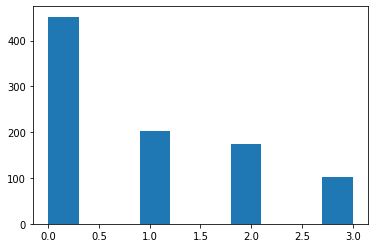

In [298]:
# print(dataloader.dataset.tensors[2].flatten())
plt.hist(dataloader.dataset.tensors[2].flatten()*2+dataloader.dataset.tensors[1].flatten())
plt.show()

===== original total select loader =====


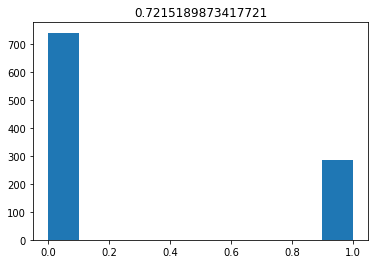

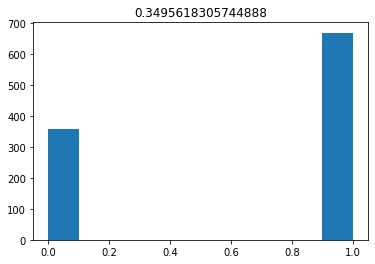

In [299]:
truez = selloader.dataset.tensors[2].flatten()
truey = selloader.dataset.tensors[1].flatten()

print("="*5,"original total select loader", "="*5)
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

In [305]:
datanum = 100

===== binary entropy for whole group gradient =====


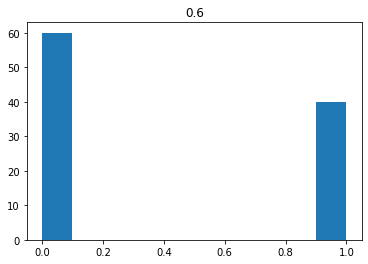

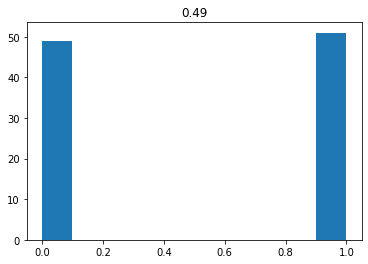

In [306]:
print("="*5,"binary entropy for whole group gradient", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs_be[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs_be[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

===== binary entropy for group 0 gradient =====


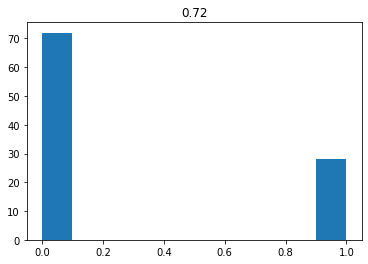

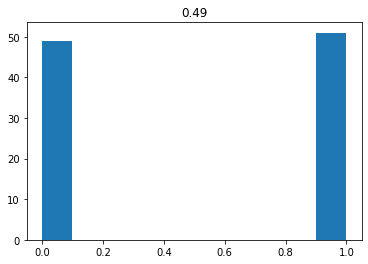

In [307]:
print("="*5,"binary entropy for group 0 gradient", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs_be0[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs_be0[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()


===== binary entropy for group 1 gradient =====


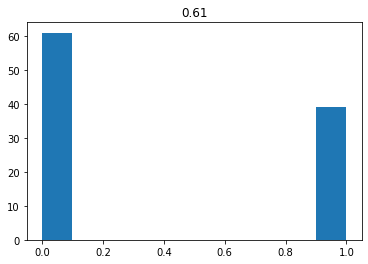

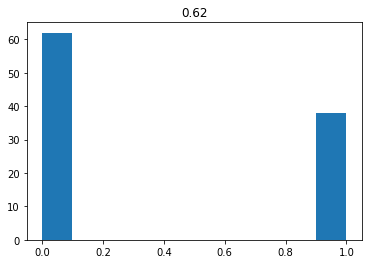

In [308]:
print("="*5,"binary entropy for group 1 gradient", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs_be1[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs_be1[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

===== entropy for all =====


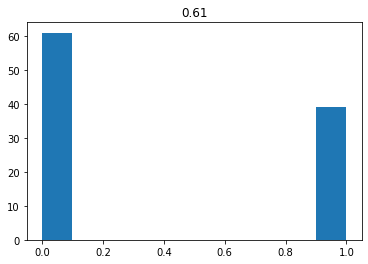

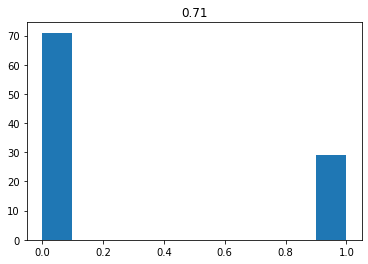

In [309]:
print("="*5,"entropy for all", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

In [71]:
torch.dot(mean_be0, mean_be1)

tensor(0.)

In [72]:
9305.4355/(129.2098*72.3006)

0.9960917601512013

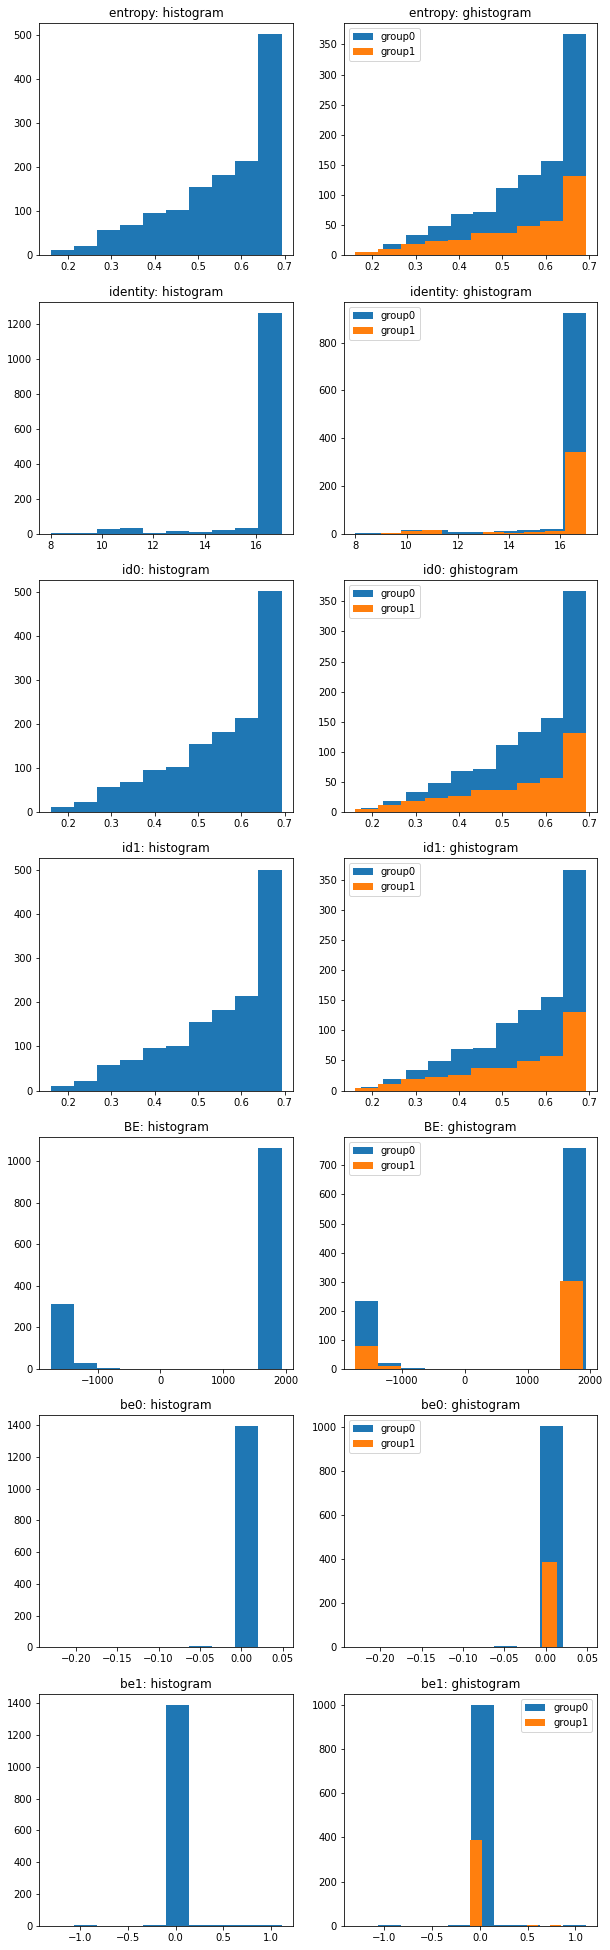

In [74]:
outs_name = ["entropy","identity","id0","id1","BE","be0","be1"]
outs_list = [max_outs,max_outs_id,max_outs_id0,max_outs_id1, max_outs_be, max_outs_be0, max_outs_be1]
plot_select_results(outs_list, selloader,outs_name)

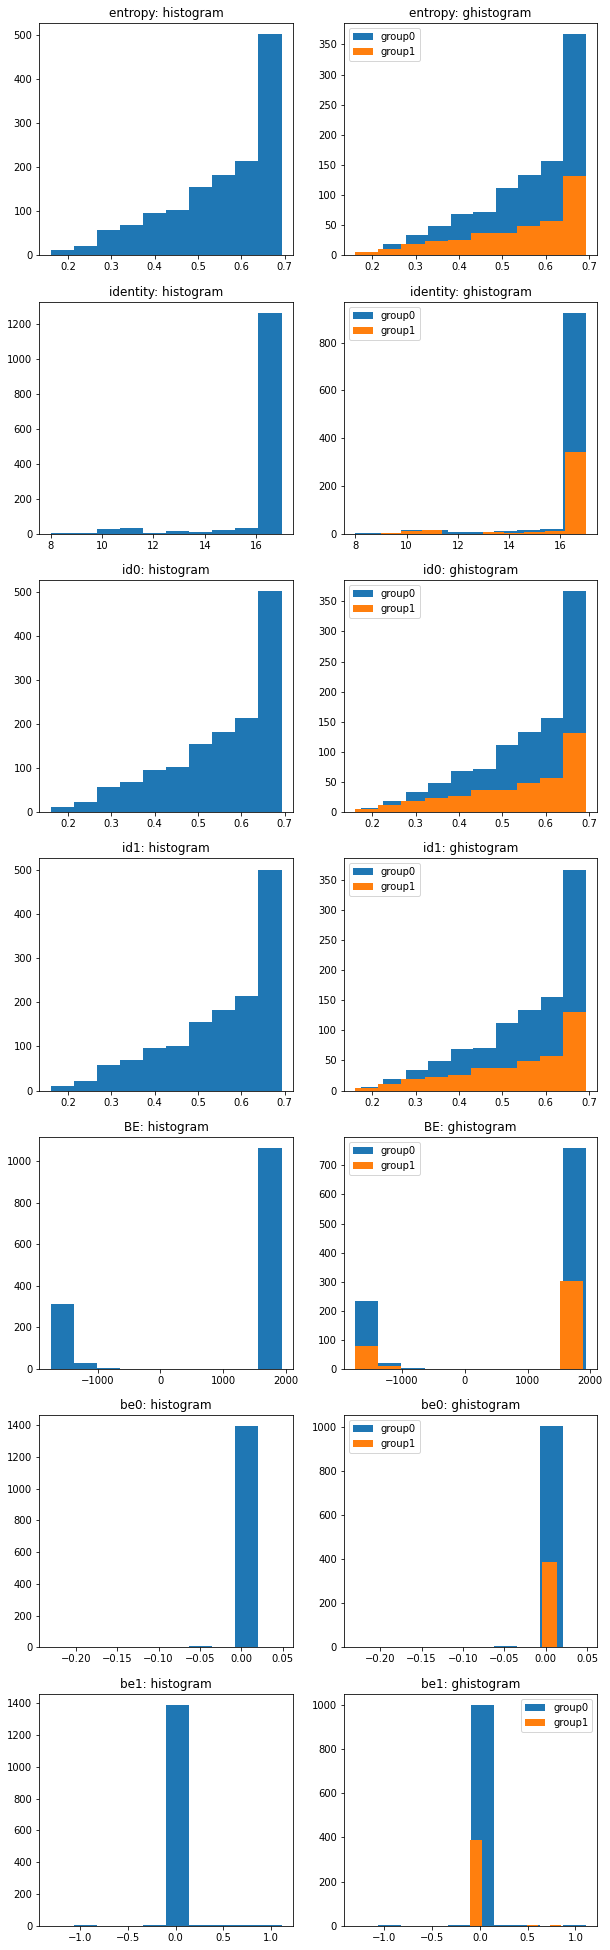

In [75]:
outs_name = ["entropy","identity","id0","id1","BE","be0","be1"]
outs_list = [max_outs,max_outs_id,max_outs_id0,max_outs_id1, max_outs_be, max_outs_be0, max_outs_be1]
plot_select_results(outs_list, selloader,outs_name)

In [369]:
from sklearn.metrics import f1_score, roc_auc_score
from utils.eval_utils import accuracy_b

def predict_model(model, test_loader, device,as_np = False):
    model.to(device).eval()
    preds = []
    ys = []
    zs = []
    with torch.no_grad():
        for batch_idx, ts in enumerate(test_loader):
            ys.append(ts[1])
            if len(ts)>2:
                zs.append(ts[2])
            preds.append(model(ts[0].to(device)).detach().cpu())
            del ts
    preds = torch.cat(preds,0)
    ys = torch.cat(ys,0)
    if len(zs)>0:
        zs = torch.cat(zs,0)
    else:
        zs = torch.tensor(zs)
    if as_np:
        return preds.numpy(), ys.numpy(), zs.numpy()
    else:
        return preds, ys, zs
def binary_scores(output, target, prob=True, thres = 0.5):
    score_dic = {}
    if prob:
        pred = torch.tensor(output>thres, dtype=torch.float32)
    else:
        pred = output
    score_dic['weighted'] = f1_score(target, pred, average='weighted')*100
    score_dic['macro'] = f1_score(target, pred, average='macro')*100
    score_dic['micro'] = f1_score(target, pred, average='micro')*100
    score_dic['accuracy'] = accuracy_b(pred, target).item()
    score_dic['roc_auc'] = roc_auc_score(target,output)*100
    
    print('weighted: ', score_dic['weighted'])
    print('macro: ',score_dic['macro'])
    print('micro: ',score_dic['micro'])            
    print('accuracy: ', score_dic['accuracy'])      
    if prob:
        print("roc auc: ", score_dic['roc_auc'])
    return score_dic
    
    
def test_binary_model(model, test_loader, device):
    preds, ys, zs = predict_model(model, test_loader, device)
    res = []
    print("="*30)
    print("binary scores for all data")
    print("="*30)
    res.append(binary_scores(preds,ys, prob=True, thres = 0.5))
    if len(zs)>0:
        zu = torch.unique(zs)
        for zi in zu:
            print("="*30)
            print("binary score for group: ",zi.item())
            print("="*30)
            zidx = zs ==zi
            res.append(binary_scores(preds[zidx].view(-1,1),ys[zidx].view(-1,1), 
                          prob=True, thres = 0.5))
    return res

In [370]:
test_binary_model(clf, test_loader, device)

binary scores for all data
weighted:  72.01866874149549
macro:  72.19264140832546
micro:  72.41379310344828
accuracy:  72.4137954711914
roc auc:  83.97669792554703
binary score for group:  0.0
weighted:  72.78757540813531
macro:  72.99190401466443
micro:  73.34437086092716
accuracy:  73.34436798095703
roc auc:  85.0381040482798
binary score for group:  1.0
weighted:  69.96214009809884
macro:  70.02298113409225
micro:  70.042194092827
accuracy:  70.04219055175781
roc auc:  81.25


<ipython-input-369-e7d3730bcace>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thres, dtype=torch.float32)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = pred.eq(target.view(1, -1).expand_as(pred))
<ipython-input-369-e7d3730bcace>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thres, dtype=torch.float32)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:41: UserWarning: To copy constru

[{'weighted': 72.01866874149549,
  'macro': 72.19264140832546,
  'micro': 72.41379310344828,
  'accuracy': 72.4137954711914,
  'roc_auc': 83.97669792554703},
 {'weighted': 72.78757540813531,
  'macro': 72.99190401466443,
  'micro': 73.34437086092716,
  'accuracy': 73.34436798095703,
  'roc_auc': 85.0381040482798},
 {'weighted': 69.96214009809884,
  'macro': 70.02298113409225,
  'micro': 70.042194092827,
  'accuracy': 70.04219055175781,
  'roc_auc': 81.25}]

In [323]:
pred_y = torch.tensor(preds>0.5, dtype = torch.float32)

<ipython-input-323-84b296f068cd>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_y = torch.tensor(preds>0.5, dtype = torch.float32)


In [328]:
from sklearn.metrics import f1_score,roc_auc_score

print(f1_score(ys, pred_y,average='weighted'))
print(f1_score(ys, pred_y,average='macro'))
print(f1_score(ys, pred_y,average='micro'))
print(roc_auc_score(ys, preds))

0.720186687414955
0.7219264140832545
0.7241379310344829
0.8397669792554703


In [15]:
for gk in loss_gs.keys():
    for gik in loss_gs[gk].keys():
        if type(loss_gs[gk][gik]) == list:
            loss_gs[gk][gik] = np.array(loss_gs[gk][gik])
        if type(acc_gs[gk][gik]) == list:
            acc_gs[gk][gik] = np.array(acc_gs[gk][gik])

In [16]:
for dtk in loss_log.keys():
    if type(loss_log[dtk]) ==list:
        loss_log[dtk] = np.array(loss_log[dtk])
    if type(acc_log[dtk]) == list:
        acc_log[dtk] = np.array(acc_log[dtk])

In [16]:
acc_log

{'train': array([61.        , 58.33333206, 64.63414764, 55.10203934, 66.22807312,
        70.7692337 , 60.27397156, 58.6419754 , 60.11235809, 67.26804352,
        60.23809433, 64.38053131, 59.71074295, 65.1162796 , 64.59854126,
        59.48275757, 59.31372452, 66.77018738, 58.43195343, 67.23163605,
        59.32432556, 61.917099  , 67.03980255, 60.64593124, 64.74654388,
        57.44444275, 55.57939911, 65.76763153, 68.7436142 ]),
 'test': array([52.49406052, 53.44417953, 57.00712585, 52.73159027, 57.24465561,
        61.28266144, 54.1567688 , 53.20664978, 54.63182831, 57.48218536,
        53.44417953, 58.66983414, 53.44417953, 57.95724487, 57.71971512,
        52.49406052, 52.49406052, 58.43230438, 52.96912003, 60.33254242,
        52.73159027, 55.81947708, 61.75772095, 57.48218536, 57.95724487,
        52.73159027, 53.91923904, 61.28266144, 62.23278046]),
 'train_w': array([55.7142868 , 54.44444275, 61.11111069, 48.87218094, 65.21739197,
        68.64865112, 56.79611588, 53.33333206

# Plot results

In [21]:
import matplotlib.pyplot as plt

In [22]:
from utils.test_utils import plot_results, load_logs

load loss group logs
load accuracy group logs
load average/worst loss logs
load average/worst accuracy logs


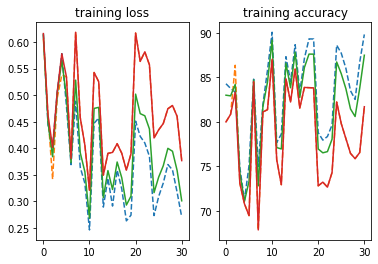

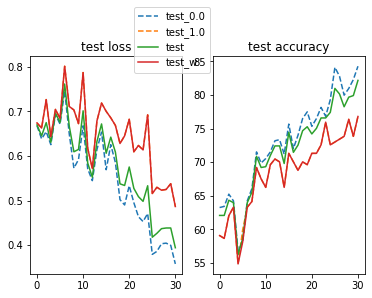

In [23]:
# save_dir = "../results/simulation/220320_1502"
loss_gs, acc_gs, loss_log, acc_log = load_logs(save_dir)
plot_results(loss_gs, acc_gs, loss_log, acc_log)

In [88]:
acc_gs

{'train': {0.0: array([81.42857361, 90.43478394, 74.69136047, 86.53845978, 88.71595001,
         78.21781921, 85.10028839, 80.15267181, 86.8181839 , 83.81742859,
         84.39306641, 82.95254517, 78.89610291, 90.54878235, 83.52272797,
         84.57447052, 83.87909698, 82.97872162, 85.1396637 , 80.65887451,
         84.14633942, 85.19230652, 84.00735474, 84.86725616, 82.45314789,
         89.09835815, 83.01737976, 83.42246246, 82.23538208, 86.01147461,
         86.9627533 ]),
  1.0: array([93.33332825, 83.67346954, 71.21212006, 80.95237732, 82.82828522,
         76.92308044, 82.96295929, 76.77419281, 80.81395721, 80.92783356,
         80.54298401, 73.61701965, 67.06349182, 81.88405609, 77.05479431,
         76.94805145, 75.75757599, 75.14620209, 75.91036224, 77.8666687 ,
         75.        , 74.75247192, 74.76190186, 76.24434662, 73.59307098,
         81.25      , 75.3012085 , 74.75915527, 73.75231171, 77.9359436 ,
         77.442276  ])},
 'test': {0.0: array([60.26490021, 66.721855

# save result logs

In [89]:
from utils.test_utils import save_logs, load_logs

In [36]:
# save_logs(save_dir, loss_gs, acc_gs, loss_log, acc_log)

save loss group logs
save accuracy group logs
save average/worst loss logs
save average/worst accuracy logs


# Load logs

In [37]:
# loss_gs, acc_gs, loss_log, acc_log = load_logs(save_dir)

load loss group logs
load accuracy group logs
load average/worst loss logs
load average/worst accuracy logs


In [90]:
dl_cum_loaders[it].dataset.tensors[1].numpy().shape

(1959, 1)

In [203]:
import numpy as np
np.unique(dl_cum_loaders[it].dataset.tensors[0].numpy(),axis=0).shape

(1959, 100)

In [204]:
from utils.data_utils import dataset_description, dl2nparray

data loader 0


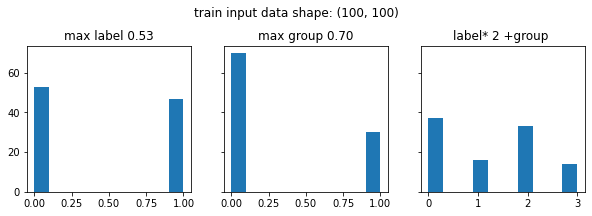

data loader 1
selected group is 1.0


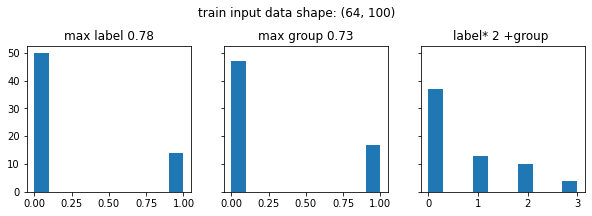

data loader 2
selected group is 0.0


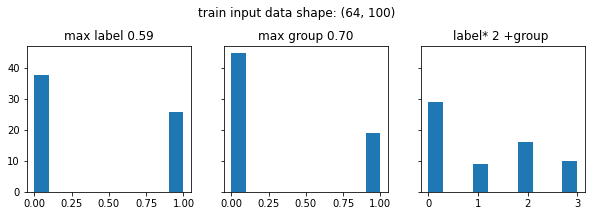

data loader 3
selected group is 0.0


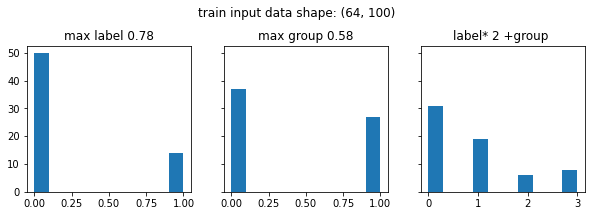

data loader 4
selected group is 0.0


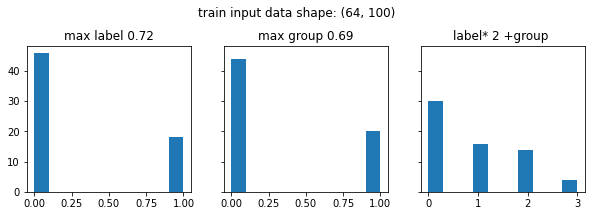

data loader 5
selected group is 1.0


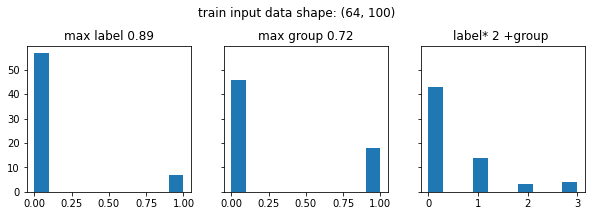

data loader 6
selected group is 0.0


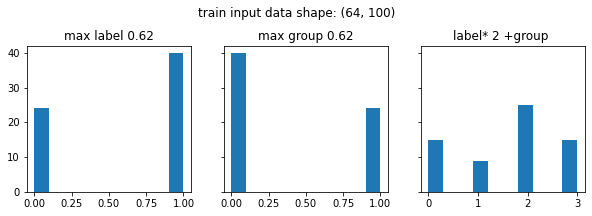

data loader 7
selected group is 0.0


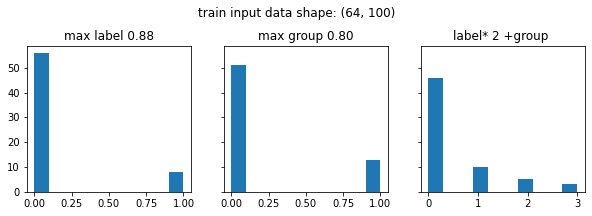

data loader 8
selected group is 1.0


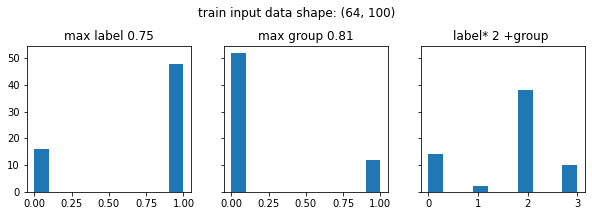

data loader 9
selected group is 0.0


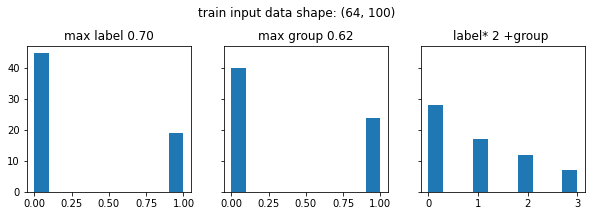

data loader 10
selected group is 0.0


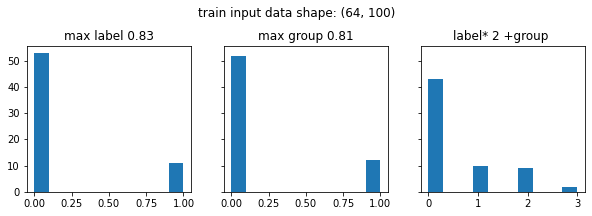

data loader 11
selected group is 1.0


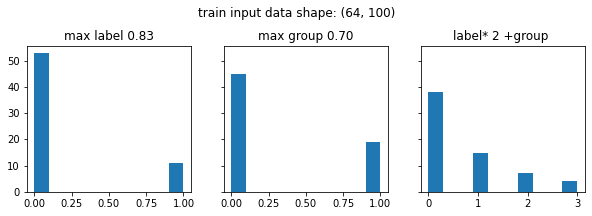

data loader 12
selected group is 0.0


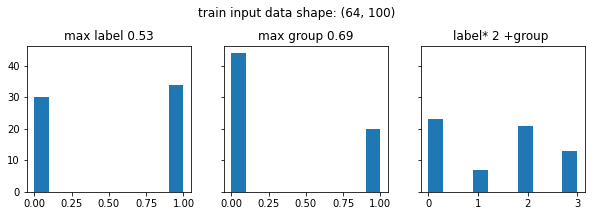

data loader 13
selected group is 0.0


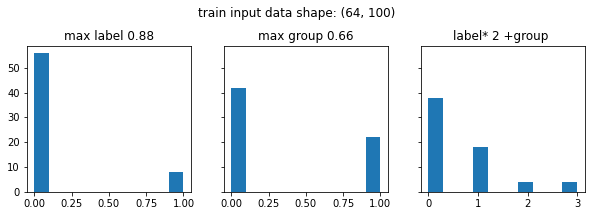

data loader 14
selected group is 0.0


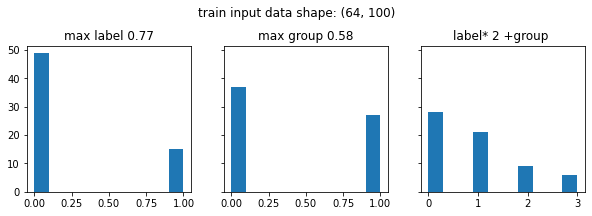

data loader 15
selected group is 1.0


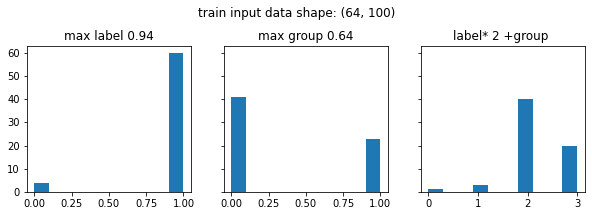

data loader 16
selected group is 1.0


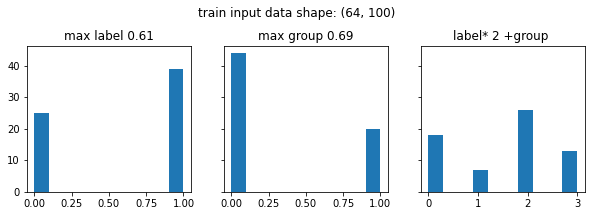

data loader 17
selected group is 1.0


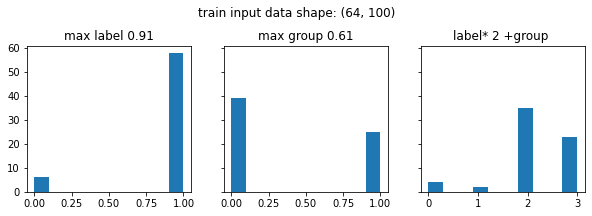

data loader 18
selected group is 0.0


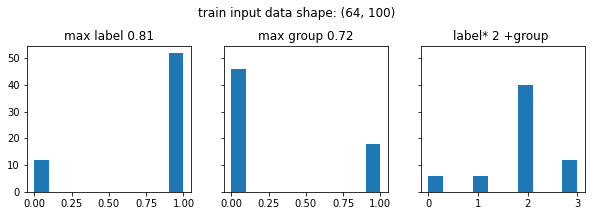

data loader 19
selected group is 0.0


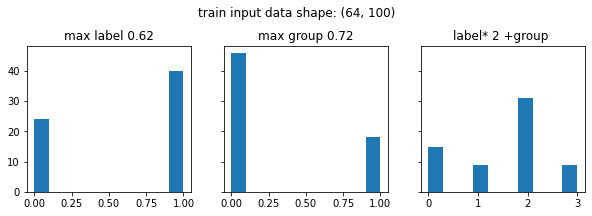

data loader 20
selected group is 0.0


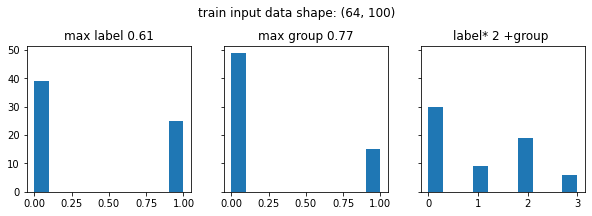

data loader 21
selected group is 1.0


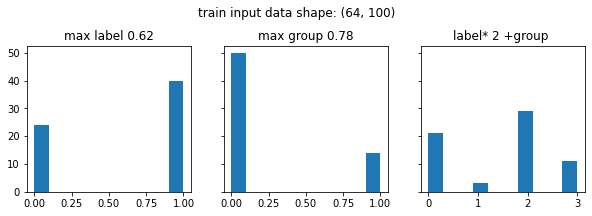

data loader 22
selected group is 1.0


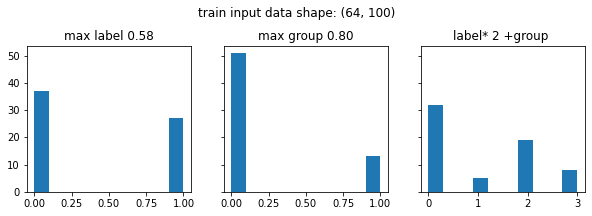

data loader 23
selected group is 0.0


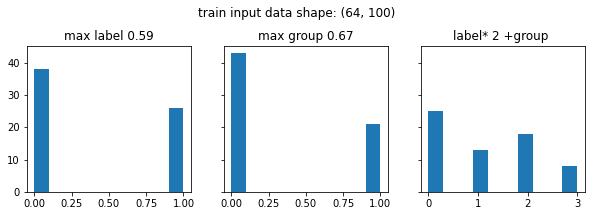

data loader 24
selected group is 0.0


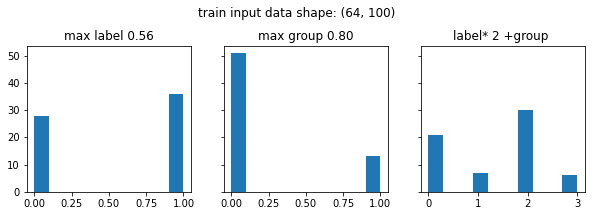

data loader 25
selected group is 1.0


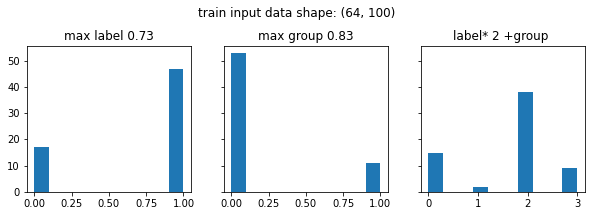

data loader 26
selected group is 1.0


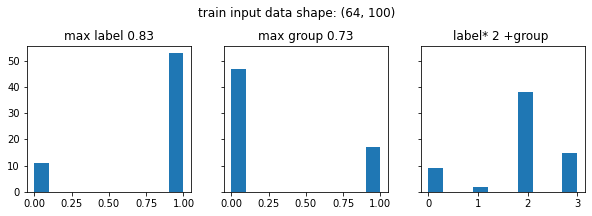

data loader 27
selected group is 1.0


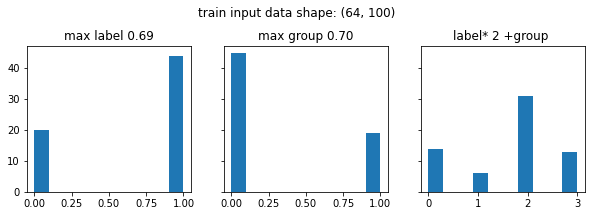

data loader 28
selected group is 1.0


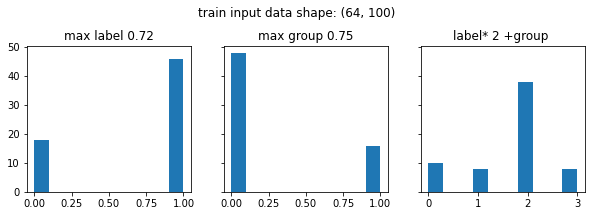

data loader 29
selected group is 0.0


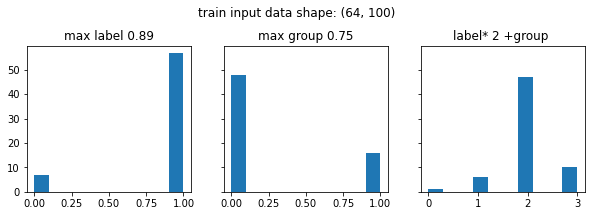

data loader 30
selected group is 1.0


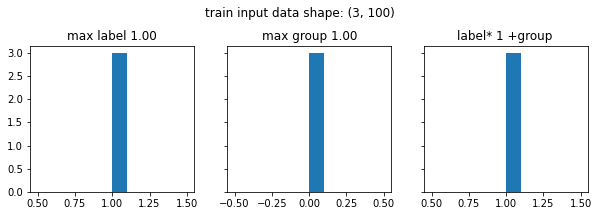

data loader 31
selected group is 1.0


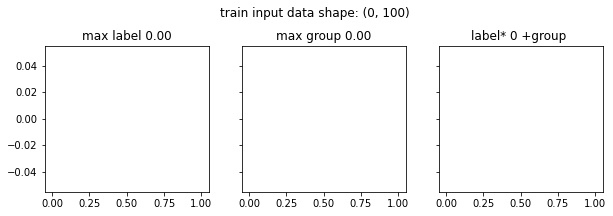

In [205]:
for i in range(len(dl_loaders)):
    print("data loader",i)
    if i>0:
        print("selected group is", gids[i-1])
    x,y,z = dl2nparray(dl_loaders[i])
    dataset_description(x,y,z)

data cumulative loader 0


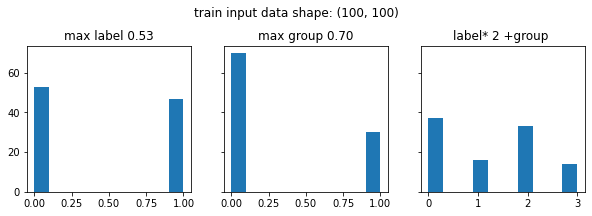

data cumulative loader 1


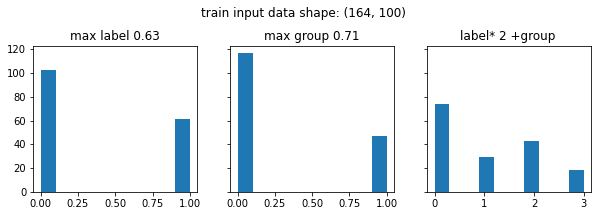

data cumulative loader 2


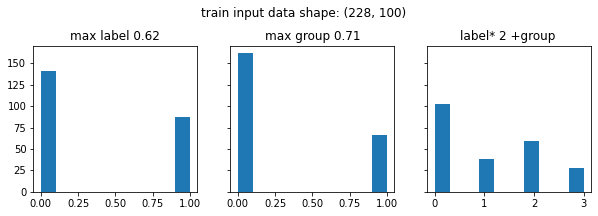

data cumulative loader 3


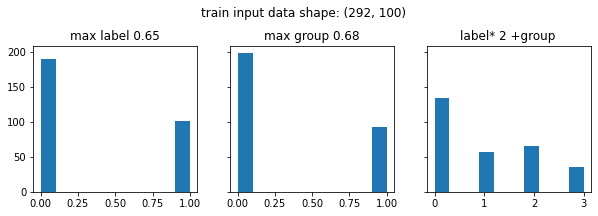

data cumulative loader 4


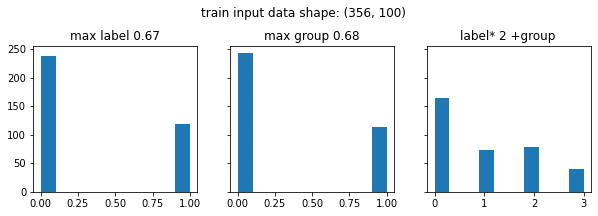

data cumulative loader 5


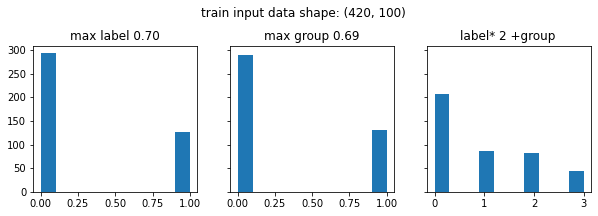

data cumulative loader 6


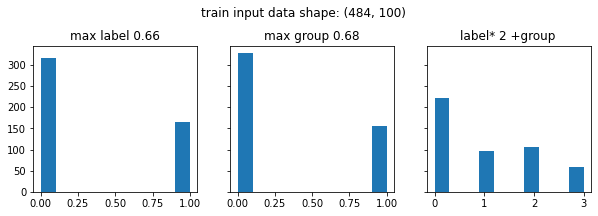

data cumulative loader 7


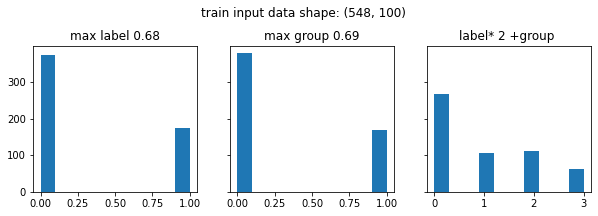

data cumulative loader 8


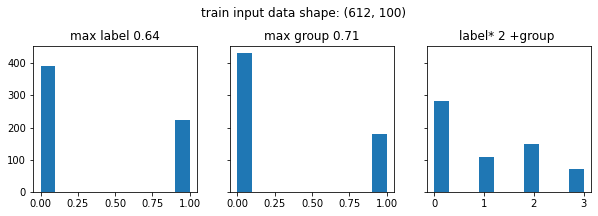

data cumulative loader 9


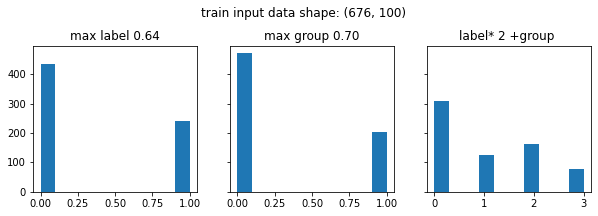

data cumulative loader 10


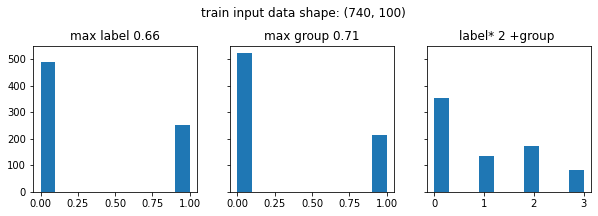

data cumulative loader 11


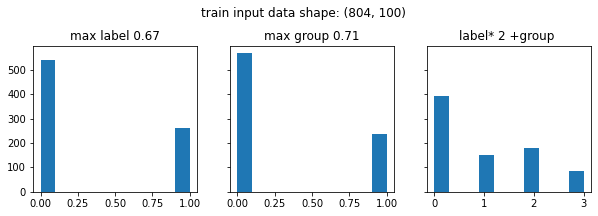

data cumulative loader 12


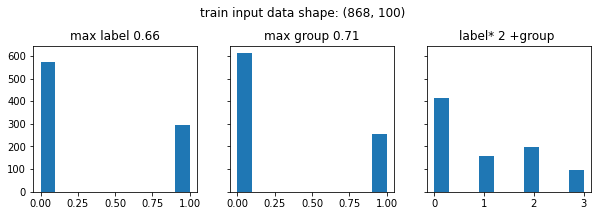

data cumulative loader 13


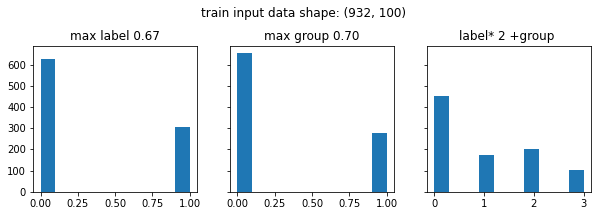

data cumulative loader 14


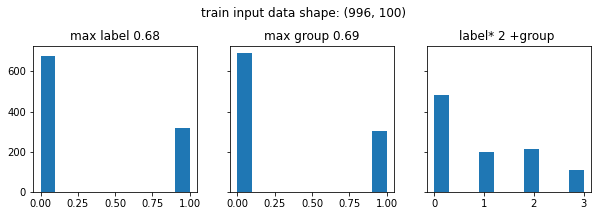

data cumulative loader 15


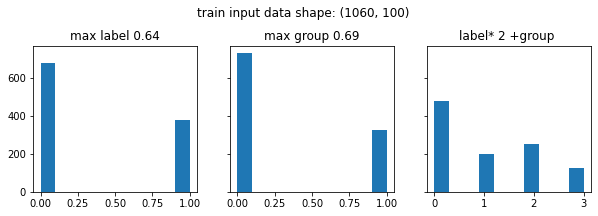

data cumulative loader 16


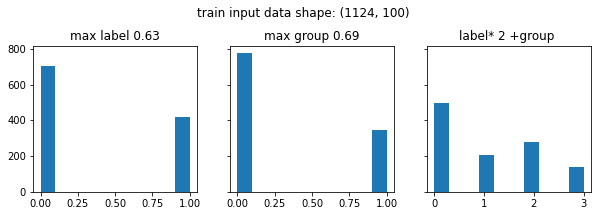

data cumulative loader 17


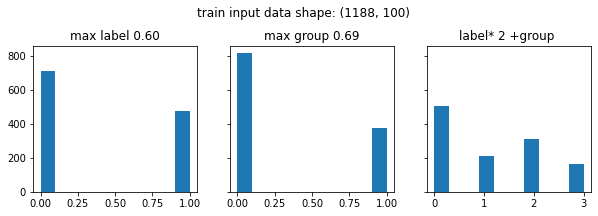

data cumulative loader 18


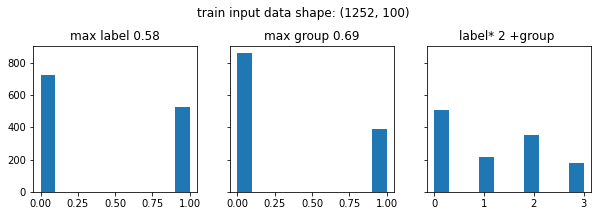

data cumulative loader 19


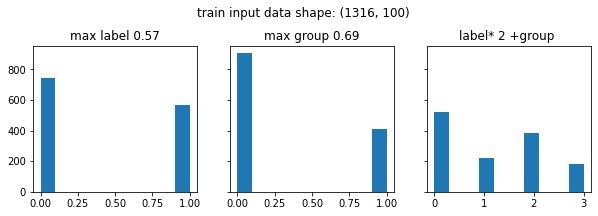

data cumulative loader 20


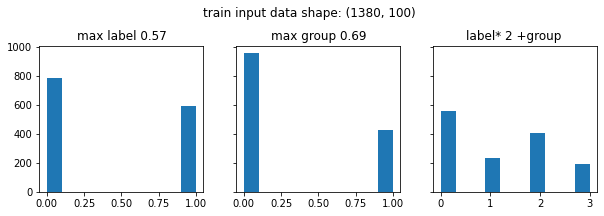

data cumulative loader 21


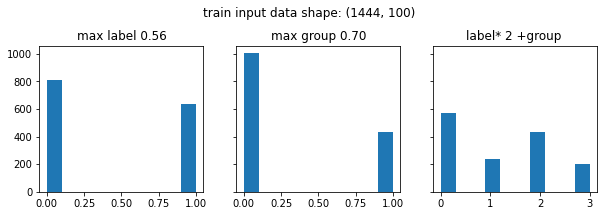

data cumulative loader 22


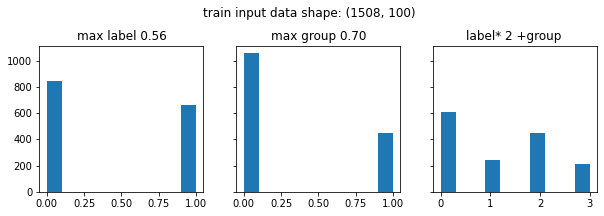

data cumulative loader 23


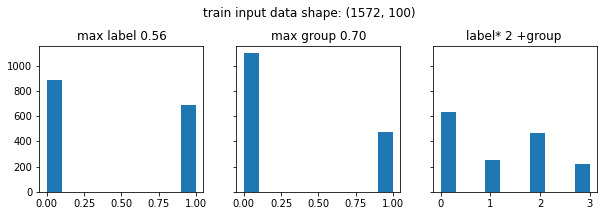

data cumulative loader 24


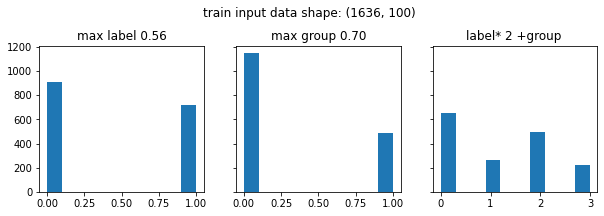

data cumulative loader 25


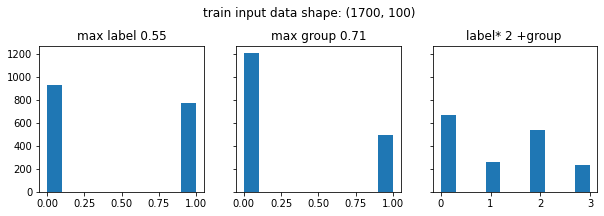

data cumulative loader 26


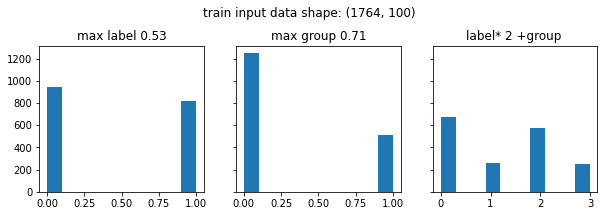

data cumulative loader 27


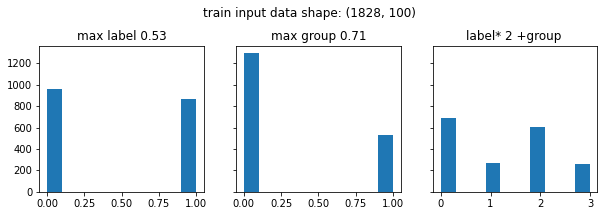

data cumulative loader 28


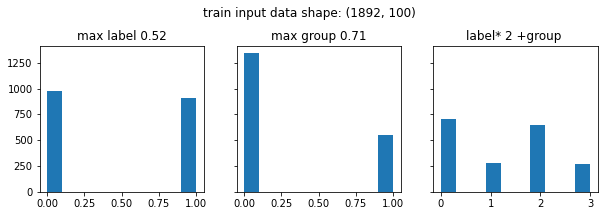

data cumulative loader 29


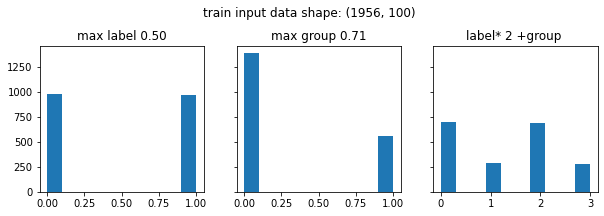

data cumulative loader 30


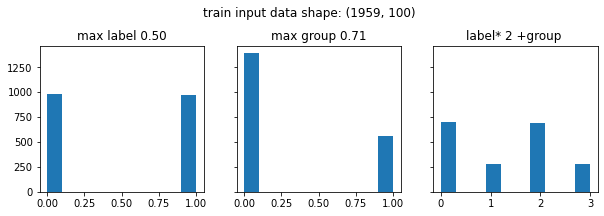

data cumulative loader 31


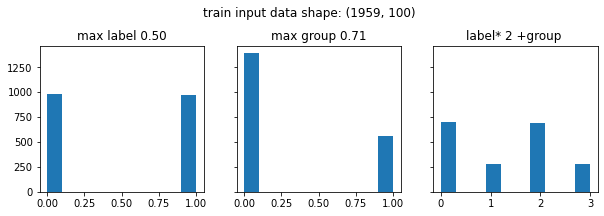

In [206]:
for i in range(len(dl_loaders)):
    print("data cumulative loader",i)
    x,y,z = dl2nparray(dl_cum_loaders[i])
    dataset_description(x,y,z)

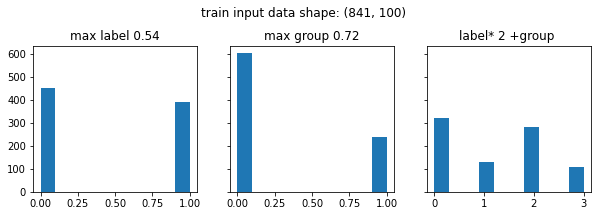

In [67]:
x,y,z = dl2nparray(test_loader)
dataset_description(x,y,z)

In [44]:
dl_loader.dataset.tensors[0].shape

torch.Size([979, 100])

In [24]:
all_acc = [0.75566667, 0.76722222, 0.77466667, 0.77977778, 0.78755556, 0.79011111,
 0.79577778, 0.806,      0.80944444, 0.81688889, 0.81366667, 0.81488889,
 0.81877778, 0.82222222, 0.82355556, 0.82644444, 0.831,      0.83077778,
 0.83188889, 0.83488889, 0.83744444, 0.83966667, 0.84344444, 0.84477778,
 0.84677778, 0.84811111, 0.848,      0.84933333, 0.85055556, 0.85277778,
 0.85344444, 0.85477778, 0.85488889, 0.85466667, 0.85622222, 0.85711111,
 0.85866667, 0.85788889, 0.85822222, 0.85966667, 0.86011111, 0.85977778,
 0.85988889, 0.86066667, 0.86033333, 0.86177778, 0.86311111, 0.86366667,
 0.86411111, 0.86433333]
g0_acc = [0.77135783, 0.78437482, 0.78984104, 0.79531273, 0.80621143, 0.80891167,
 0.81410646, 0.82522084, 0.8325519,  0.84001331, 0.83800748, 0.83881225,
 0.84165849, 0.84611088, 0.84898955, 0.8516169,  0.85518775, 0.8547969,
 0.85494712, 0.85691775, 0.85857554, 0.86021653, 0.86572802, 0.8693151,
 0.86948487, 0.8710667, 0.87265362, 0.87324681, 0.87525863, 0.87727422,
 0.87852759, 0.87855987, 0.8790869,  0.87795619, 0.88171829, 0.88160499,
 0.88428235, 0.88346264, 0.88461992, 0.88593628, 0.88682345, 0.88664032,
 0.88643486, 0.88684121, 0.88746477, 0.88848734, 0.8891692,  0.89000469,
 0.88986754, 0.89040337]
g1_acc = [0.72355469, 0.73305028, 0.74425323, 0.74892322, 0.75039487, 0.75297968,
 0.75927363, 0.76795712, 0.76353601, 0.77125807, 0.76565339, 0.76756775,
 0.77376304, 0.77489073, 0.77317274, 0.77654372, 0.78319812, 0.78311853,
 0.78604878, 0.79117314, 0.79554044, 0.79885397, 0.79938937, 0.79607359,
 0.8018151,  0.80278036, 0.79910147, 0.80202763, 0.80179627, 0.80438192,
 0.80356491, 0.80761856, 0.8068824,  0.80854015, 0.80563596, 0.80870681,
 0.80792594, 0.80720564, 0.80596873, 0.80759637, 0.80741074, 0.80668419,
 0.80728143, 0.8090055,  0.80666541, 0.80910232, 0.81167961, 0.81168477,
 0.81351565, 0.81304232]

In [28]:
all_acc_rs = [0.75566667,0.76722222,0.77466667,0.77977778,0.78755556,0.79011111,0.79577778,0.806,0.80944444,0.81688889,0.81366667,0.81488889,0.81877778,0.82222222,0.82355556,0.82644444,0.831,0.83077778,0.83188889,0.83488889,0.83744444,0.83966667,0.84344444,0.84477778,0.84677778,0.84811111,0.848,0.84933333,0.85055556,0.85277778,0.85344444,0.85477778,0.85488889,0.85466667,0.85622222,0.85711111,0.85866667,0.85788889,0.85822222,0.85966667,0.86011111,0.85977778,0.85988889,0.86066667,0.86033333,0.86177778,0.86311111,0.86366667,0.86411111,0.86433333]
g0_acc_rs = [0.77135783,0.78437482,0.78984104,0.79531273,0.80621143,0.80891167,0.81410646,0.82522084,0.8325519,0.84001331,0.83800748,0.83881225,0.84165849,0.84611088,0.84898955,0.8516169,0.85518775,0.8547969,0.85494712,0.85691775,0.85857554,0.86021653,0.86572802,0.8693151,0.86948487,0.8710667,0.87265362,0.87324681,0.87525863,0.87727422,0.87852759,0.87855987,0.8790869,0.87795619,0.88171829,0.88160499,0.88428235,0.88346264,0.88461992,0.88593628,0.88682345,0.88664032,0.88643486,0.88684121,0.88746477,0.88848734,0.8891692,0.89000469,0.88986754,0.89040337]
g1_acc_rs = [0.72355469,0.73305028,0.74425323,0.74892322,0.75039487,0.75297968,0.75927363,0.76795712,0.76353601,0.77125807,0.76565339,0.76756775,0.77376304,0.77489073,0.77317274,0.77654372,0.78319812,0.78311853,0.78604878,0.79117314,0.79554044,0.79885397,0.79938937,0.79607359,0.8018151,0.80278036,0.79910147,0.80202763,0.80179627,0.80438192,0.80356491,0.80761856,0.8068824,0.80854015,0.80563596,0.80870681,0.80792594,0.80720564,0.80596873,0.80759637,0.80741074,0.80668419,0.80728143,0.8090055,0.80666541,0.80910232,0.81167961,0.81168477,0.81351565,0.81304232]

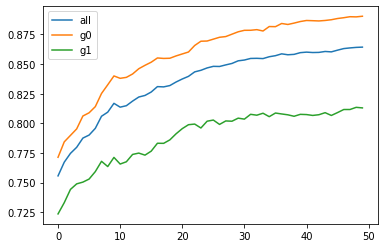

In [26]:
plt.figure()
plt.plot(all_acc, '-',label='all')
plt.plot(g0_acc, '-',label='g0')
plt.plot(g1_acc, '-',label='g1')
plt.legend()
plt.show()

In [29]:
all_acc_us = [0.75566667,0.77855556,0.78688889,0.79555556,0.80144444,0.80888889,0.82011111,0.82411111,0.833,0.83833333,0.839,0.842,0.84911111,0.85122222,0.85266667,0.85533333,0.861,0.85922222,0.86166667,0.86255556,0.86666667,0.86455556,0.86777778,0.86911111,0.87022222,0.86822222,0.86633333,0.87055556,0.869,0.87277778,0.87111111,0.87155556,0.87411111,0.87422222,0.87433333,0.87322222,0.873,0.87422222,0.87377778,0.87488889,0.87477778,0.87366667,0.87288889,0.87244444,0.87411111,0.87266667,0.873,0.87466667,0.87322222,0.87411111]
g0_acc_us = [0.77135783,0.79232917,0.8045743,0.81515017,0.82133451,0.83107213,0.84547699,0.85123612,0.8639673,0.86962077,0.87244007,0.87785794,0.88220908,0.88233308,0.88607192,0.8909066,0.89645433,0.89565418,0.90025109,0.90022005,0.905322,0.90120214,0.90447016,0.90916511,0.90868526,0.90644912,0.90743099,0.9127946,0.90832645,0.91193772,0.90975131,0.91178506,0.91294785,0.91146214,0.9124857,0.91084084,0.91101661,0.91188025,0.90997869,0.91001666,0.91055731,0.90837789,0.90721098,0.90651274,0.90790005,0.90722506,0.90727218,0.90775354,0.90605527,0.90736732]
g1_acc_us = [0.72355469,0.75064129,0.75129558,0.75643016,0.76180867,0.7646963,0.76969386,0.77073951,0.77171044,0.77628434,0.77250991,0.77091409,0.7838604,0.78969206,0.78683055,0.78489658,0.79072676,0.78734122,0.78535095,0.7879029,0.790329,0.79229371,0.79541343,0.79020929,0.79455261,0.79271845,0.78520405,0.78724483,0.79122754,0.79567944,0.79479328,0.79224083,0.79758263,0.80088443,0.79931262,0.79917795,0.79843472,0.80023601,0.80261916,0.80589312,0.80457339,0.80537821,0.80548567,0.80557049,0.80786932,0.80486854,0.80591483,0.80986711,0.80887487,0.80887718]

In [30]:
all_acc_gbe = [0.75566667,0.76033333,0.76122222,0.76522222,0.77088889,0.77,0.77255556,0.77011111,0.77577778,0.77622222,0.77911111,0.77888889,0.78222222,0.78155556,0.78244444,0.78544444,0.78311111,0.78766667,0.786,0.788,0.78555556,0.78555556,0.78422222,0.788,0.79055556,0.79066667,0.78922222,0.79066667,0.79511111,0.79422222,0.79411111,0.79566667,0.79911111,0.79888889,0.79944444,0.79977778,0.79977778,0.80455556,0.80666667,0.81077778,0.81211111,0.81344444,0.81977778,0.81844444,0.82055556,0.82522222,0.82644444,0.82855556,0.83133333,0.83344444]
g0_acc_gbe = [0.77135783,0.77494505,0.77416674,0.77764057,0.78446408,0.78552971,0.78777574,0.78314689,0.78720094,0.78816225,0.79305198,0.79554928,0.79738359,0.79536723,0.79669732,0.80106507,0.79888635,0.80211414,0.80079732,0.80138258,0.7979669,0.79985476,0.79712878,0.80155358,0.80305499,0.80424265,0.80326887,0.80459648,0.80918547,0.80780983,0.80746825,0.80864267,0.81027605,0.80996556,0.81040434,0.81218445,0.81192845,0.81791252,0.82145958,0.82590961,0.82970126,0.83055745,0.83751361,0.83822383,0.84070497,0.84586807,0.84621765,0.84810223,0.85170083,0.85317593]
g1_acc_gbe = [0.72355469,0.73095801,0.73533135,0.74049779,0.74383863,0.73931462,0.74273318,0.74470555,0.75363706,0.75287441,0.75134963,0.74589539,0.7518996,0.75393321,0.75382604,0.75419676,0.75170204,0.7590416,0.75662171,0.76109738,0.76053766,0.7570277,0.758133,0.76063551,0.76539167,0.76358141,0.7612069,0.76298985,0.76736995,0.76737591,0.76753182,0.76998181,0.77691256,0.77709874,0.77792355,0.77512384,0.77587973,0.77808938,0.77750714,0.78060062,0.77723041,0.77961229,0.78454749,0.77920239,0.78078647,0.78434227,0.78731296,0.79001721,0.79100282,0.79433737]

In [31]:
all_acc_gpr = [0.75566667,0.765,0.77011111,0.77177778,0.77944444,0.77844444,0.77911111,0.77855556,0.78422222,0.788,0.78988889,0.79366667,0.79655556,0.79888889,0.80222222,0.80755556,0.81211111,0.81333333,0.816,0.81788889,0.81966667,0.819,0.82022222,0.82322222,0.82577778,0.82655556,0.83088889,0.832,0.83344444,0.83633333,0.83966667,0.83822222,0.84133333,0.84088889,0.84266667,0.84355556,0.84611111,0.84155556,0.84233333,0.84677778,0.84788889,0.849,0.85044444,0.85166667,0.85222222,0.85588889,0.85511111,0.856,0.85644444,0.859]
g0_acc_gpr = [0.77135783,0.78086766,0.7857089,0.78479948,0.79439534,0.79438154,0.796156,0.79658935,0.80308596,0.80711998,0.80800638,0.81285579,0.81574851,0.81990863,0.82457883,0.82892221,0.83212143,0.83124235,0.83662347,0.83825463,0.83878276,0.83651323,0.83689771,0.83902667,0.84206185,0.84226993,0.84864977,0.84982515,0.85264056,0.85589674,0.8583788,0.8569644,0.86212521,0.86012065,0.86220671,0.86298821,0.86500227,0.85982224,0.86220974,0.86791235,0.8687253,0.86821499,0.86987129,0.87153034,0.87203396,0.87718741,0.87685425,0.87724942,0.87773594,0.88086883]
g1_acc_gpr = [0.72355469,0.73301914,0.73833184,0.74557234,0.749868,0.74664053,0.74565321,0.74311847,0.74677786,0.75032102,0.75432737,0.75590936,0.75875622,0.75783552,0.75823261,0.76554156,0.77304777,0.7786166,0.77564447,0.77838088,0.78281041,0.7852975,0.78813453,0.79290765,0.79439942,0.79587235,0.79610229,0.79710005,0.79575062,0.79817736,0.80318746,0.80154281,0.80059328,0.80318259,0.80454905,0.80535255,0.80904741,0.80569559,0.8032721,0.80517569,0.80704846,0.81138586,0.81241023,0.812824,0.81341224,0.81401641,0.81264275,0.81461507,0.81492037,0.81622449]

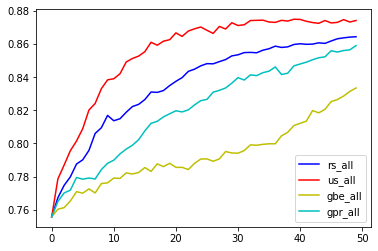

In [36]:
plt.figure()
plt.plot(all_acc_rs, label='rs_all', c = 'b')
plt.plot(all_acc_us, label='us_all', c = 'r')
plt.plot(all_acc_gbe, label='gbe_all', c = 'y')
plt.plot(all_acc_gpr, label='gpr_all', c = 'c')
plt.legend()
plt.show()

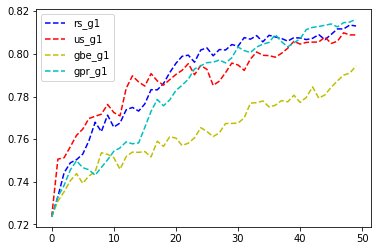

In [37]:
plt.figure()
plt.plot(g1_acc_rs, '--', label='rs_g1', c = 'b')
plt.plot(g1_acc_us, '--', label='us_g1', c = 'r')
plt.plot(g1_acc_gbe, '--', label='gbe_g1', c = 'y')
plt.plot(g1_acc_gpr, '--', label='gpr_g1', c = 'c')
plt.legend()
plt.show()

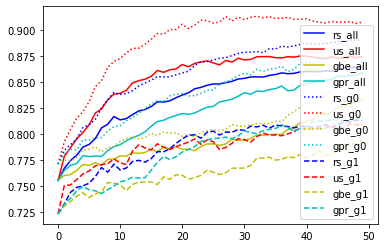

In [40]:
plt.figure()
plt.plot(all_acc_rs, label='rs_all', c = 'b')
plt.plot(all_acc_us, label='us_all', c = 'r')
plt.plot(all_acc_gbe, label='gbe_all', c = 'y')
plt.plot(all_acc_gpr, label='gpr_all', c = 'c')
plt.plot(g0_acc_rs, ':', label='rs_g0', c = 'b')
plt.plot(g0_acc_us, ':', label='us_g0', c = 'r')
plt.plot(g0_acc_gbe, ':', label='gbe_g0', c = 'y')
plt.plot(g0_acc_gpr, ':', label='gpr_g0', c = 'c')
plt.plot(g1_acc_rs, '--', label='rs_g1', c = 'b')
plt.plot(g1_acc_us, '--', label='us_g1', c = 'r')
plt.plot(g1_acc_gbe, '--', label='gbe_g1', c = 'y')
plt.plot(g1_acc_gpr, '--', label='gpr_g1', c = 'c')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(all_acc_rs, label='rs_all')
plt.plot(all_acc_us, label='us_all')
plt.plot(all_acc_gbe, label='gbe_all')
plt.plot(all_acc_gpr, label='gpr_all')
plt.legend()
plt.show()

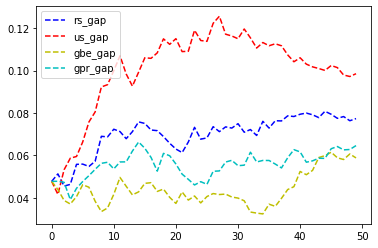

In [68]:
import numpy as np
plt.figure()
plt.plot(np.array(g0_acc_rs)-np.array(g1_acc_rs), '--', label='rs_gap', c = 'b')
plt.plot(np.array(g0_acc_us)-np.array(g1_acc_us), '--', label='us_gap', c = 'r')
plt.plot(np.array(g0_acc_gbe)-np.array(g1_acc_gbe), '--', label='gbe_gap', c = 'y')
plt.plot(np.array(g0_acc_gpr)-np.array(g1_acc_gpr), '--', label='gpr_gap', c = 'c')
plt.legend()
plt.show()